In [1]:
# need environment: environment returns next state based on action
# need an actor: actor decides the next action based on the state
# need a reward function: how do you train the reward function?

In [2]:
# the actor samples from a certain direction with variance, computes all trajectories

In [ ]:
# can you even train a neural network from scratch?

In [ ]:
# goal of today: implement a working first version of PPO from first principles

# 1. Implement NN in Pytorch

In [5]:
# first, let's check if I know how NNs work

In [ ]:
# conv1D(), conv2D()
# cross-correlation: sliding dot-product of a kernel with the signal

In [78]:
import torch
from torch.nn import Conv1d, Conv2d

In [79]:
input = torch.randn(2,3)

In [80]:
input

tensor([[ 0.1697, -2.5996, -0.2023],
        [ 1.5400, -0.3654, -1.1400]])

In [87]:
m = Conv1d(2,33,1)

In [90]:
# consider this as m^T x input

In [91]:
m(input).shape

torch.Size([33, 3])

In [92]:
m

Conv1d(2, 33, kernel_size=(1,), stride=(1,))

In [93]:
rand_arr = torch.rand(1,5,3)

In [94]:
rand_arr

tensor([[[0.8958, 0.1521, 0.9988],
         [0.4593, 0.2606, 0.5930],
         [0.2712, 0.3456, 0.7567],
         [0.4024, 0.5362, 0.4682],
         [0.9070, 0.4886, 0.3686]]])

In [99]:
rand_arr_permute = rand_arr.permute(0,2,1)

In [110]:
rand_arr.shape

torch.Size([1, 5, 3])

In [111]:
rand_arr_permute.shape

torch.Size([1, 3, 5])

In [125]:
rand_arr_permute

tensor([[[0.8958, 0.4593, 0.2712, 0.4024, 0.9070],
         [0.1521, 0.2606, 0.3456, 0.5362, 0.4886],
         [0.9988, 0.5930, 0.7567, 0.4682, 0.3686]]])

In [131]:
conv1 = Conv1d(3,1,1)

In [132]:
conv1.weight

Parameter containing:
tensor([[[0.0405],
         [0.4572],
         [0.3629]]], requires_grad=True)

In [141]:
conv1.bias

Parameter containing:
tensor([-0.4196], requires_grad=True)

In [134]:
conv1(rand_arr_permute)

tensor([[[ 0.0487, -0.0667,  0.0240,  0.0118, -0.0257]]],
       grad_fn=<ConvolutionBackward0>)

In [148]:
# this is the same as

In [173]:
conv1.weight.shape

torch.Size([1, 3, 1])

In [172]:
conv1.weight.squeeze(-1).shape

torch.Size([1, 3])

In [174]:
rand_arr_permute.shape

torch.Size([1, 3, 5])

In [176]:
rand_arr_permute.squeeze(0).shape

torch.Size([3, 5])

In [149]:
conv1.weight.squeeze(-1) @ rand_arr_permute.squeeze(0) + conv1.bias

tensor([[ 0.0487, -0.0667,  0.0240,  0.0118, -0.0257]], grad_fn=<AddBackward0>)

In [120]:
# why is it different everytime - because Conv1d randomly initializes the weights

In [151]:
# but if we do a >1 kernel dimension

In [153]:
conv1plus = Conv1d(3,5,1)

In [155]:
conv1plus.weight

Parameter containing:
tensor([[[ 0.5221],
         [ 0.2429],
         [-0.4916]],

        [[-0.1549],
         [ 0.4406],
         [ 0.1943]],

        [[ 0.5434],
         [-0.3092],
         [-0.0287]],

        [[-0.3447],
         [-0.1509],
         [-0.2360]],

        [[ 0.4997],
         [ 0.1476],
         [-0.0787]]], requires_grad=True)

In [157]:
rand_arr_permute

tensor([[[0.8958, 0.4593, 0.2712, 0.4024, 0.9070],
         [0.1521, 0.2606, 0.3456, 0.5362, 0.4886],
         [0.9988, 0.5930, 0.7567, 0.4682, 0.3686]]])

In [160]:
conv1(rand_arr_permute).shape

torch.Size([1, 1, 5])

In [161]:
conv1plus(rand_arr_permute).shape

torch.Size([1, 5, 5])

In [162]:
# my question is: what's the point then of having a >1 length kernel?
# oh, it seems like this is just the same as matrix multiplicaton

In [179]:
conv1plus.weight.squeeze(-1) @ rand_arr_permute.squeeze(0) + conv1plus.bias

tensor([[-0.1588,  0.0951, -0.5309, -0.4485, -0.0710],
        [-0.0502,  0.2424, -0.1273, -0.2938, -0.3357],
        [ 0.2387,  0.2356, -0.3656, -0.5192, -0.1508],
        [-0.7399, -0.2540, -0.7087, -0.8888, -0.9554],
        [ 0.2190,  0.3048, -0.2575, -0.3153,  0.0143]], grad_fn=<AddBackward0>)

In [182]:
(conv1plus.weight.squeeze(-1) @ rand_arr_permute.squeeze(0) + conv1plus.bias).shape

torch.Size([5, 5])

In [181]:
conv1plus(rand_arr_permute).shape

torch.Size([1, 5, 5])

## 1.1 2D Neural Network on MNIST Dataset

In [2]:
import torch.nn as nn
import torch.nn.functional as F

In [191]:
!pip install torchvision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 30.4 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.6/68.6 MB 20.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 34.6 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.4.0
    Uninstalling typing_extensions-4.4.0:
      Successfully uninstalled typing_extensions-4.4.0
  Attempting uninstall: sympy
    Found existing installation: sympy 1.11.1
    Uninstalling sympy-1.11.1:
      Successfully uninstalled sympy-1.11.1
  Attempting uninstall: torch
    Found existing installation: torch 1.12.1
    Uninstalling torch-1.12.1:
      Successfully uninstalled torch-1.12.1


In [11]:
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms

In [52]:
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307,), (0.3081,))])

In [53]:
train_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform = transform
)

In [420]:
train_dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )

In [406]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

In [407]:
import matplotlib.pyplot as plt
import numpy as np

In [408]:
data_iter = iter(train_loader)

In [409]:
images, labels = next(data_iter)

In [410]:
images.shape

torch.Size([8, 1, 28, 28])

In [411]:
len(label)

64

In [412]:
image_np = images.squeeze().numpy()

In [413]:
image_np.shape

(8, 28, 28)

In [414]:
import torch

In [393]:
labels = torch.tensor([3,3,3,9,3,7,6,3,6,3,0,7,2,2,1,6,9,0,3,0,3,0,1,7,5,7,3,5,3,0,1,6,2,6,8,4,7,9,6,1,4,6,6,3,2,7,9,8,2,1,9,3,2,7,0,1,6,2,1,0,9,9,3,2])

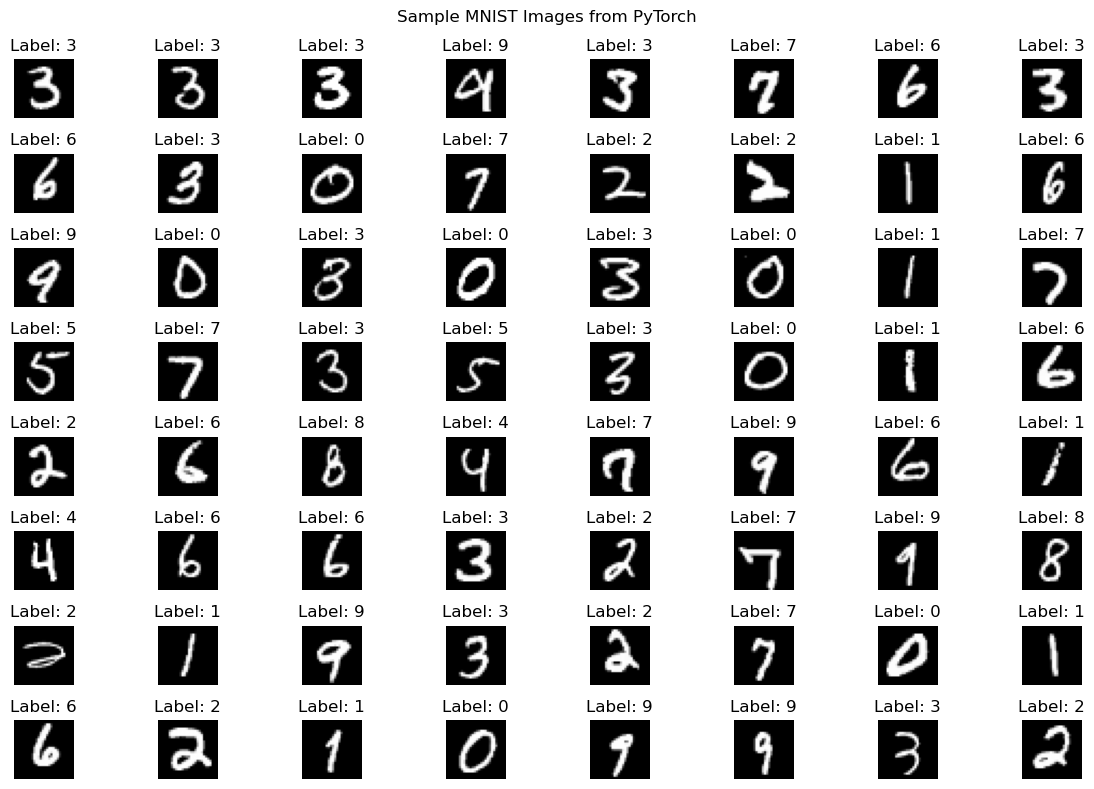

In [394]:
plt.figure(figsize=(12, 8))
for i in range(64):
    plt.subplot(8, 8, i + 1)
    plt.imshow(images_np[i], cmap='gray')
    plt.title(f'Label: {labels[i].item()}')
    plt.axis('off')
plt.suptitle('Sample MNIST Images from PyTorch')
plt.tight_layout()
plt.show()

In [383]:
train_loader

In [397]:
for batch_ndx, sample in enumerate(train_loader):
    print(batch_ndx)
#     print(sample)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066
2067
2068
2069
2070
2071
2072
2073
2074
2075
2076
2077
2078
2079
2080
2081
2082
2083
2084
2085
2086
2087
2088
2089
2090
2091
2092
2093
2094
2095
2096
2097
2098
2099
2100
2101
2102
2103
2104
2105
2106
2107
2108
2109
2110
2111
2112
2113
2114
2115
2116
2117
2118
2119
2120
2121
2122
2123
2124
2125
2126
2127
2128
2129
2130
2131
2132
2133
2134
2135
2136
2137
2138
2139
2140
2141
2142
2143
2144
2145
2146
2147
2148
2149
2150
2151
2152
2153
2154
2155
2156
2157
2158
2159
2160
2161
2162
2163
2164
2165
2166
2167
2168
2169
2170
2171
2172
2173
2174
2175
2176
2177
2178
2179
2180
2181


4074
4075
4076
4077
4078
4079
4080
4081
4082
4083
4084
4085
4086
4087
4088
4089
4090
4091
4092
4093
4094
4095
4096
4097
4098
4099
4100
4101
4102
4103
4104
4105
4106
4107
4108
4109
4110
4111
4112
4113
4114
4115
4116
4117
4118
4119
4120
4121
4122
4123
4124
4125
4126
4127
4128
4129
4130
4131
4132
4133
4134
4135
4136
4137
4138
4139
4140
4141
4142
4143
4144
4145
4146
4147
4148
4149
4150
4151
4152
4153
4154
4155
4156
4157
4158
4159
4160
4161
4162
4163
4164
4165
4166
4167
4168
4169
4170
4171
4172
4173
4174
4175
4176
4177
4178
4179
4180
4181
4182
4183
4184
4185
4186
4187
4188
4189
4190
4191
4192
4193
4194
4195
4196
4197
4198
4199
4200
4201
4202
4203
4204
4205
4206
4207
4208
4209
4210
4211
4212
4213
4214
4215
4216
4217
4218
4219
4220
4221
4222
4223
4224
4225
4226
4227
4228
4229
4230
4231
4232
4233
4234
4235
4236
4237
4238
4239
4240
4241
4242
4243
4244
4245
4246
4247
4248
4249
4250
4251
4252
4253
4254
4255
4256
4257
4258
4259
4260
4261
4262
4263
4264
4265
4266
4267
4268
4269
4270
4271
4272
4273


6148
6149
6150
6151
6152
6153
6154
6155
6156
6157
6158
6159
6160
6161
6162
6163
6164
6165
6166
6167
6168
6169
6170
6171
6172
6173
6174
6175
6176
6177
6178
6179
6180
6181
6182
6183
6184
6185
6186
6187
6188
6189
6190
6191
6192
6193
6194
6195
6196
6197
6198
6199
6200
6201
6202
6203
6204
6205
6206
6207
6208
6209
6210
6211
6212
6213
6214
6215
6216
6217
6218
6219
6220
6221
6222
6223
6224
6225
6226
6227
6228
6229
6230
6231
6232
6233
6234
6235
6236
6237
6238
6239
6240
6241
6242
6243
6244
6245
6246
6247
6248
6249
6250
6251
6252
6253
6254
6255
6256
6257
6258
6259
6260
6261
6262
6263
6264
6265
6266
6267
6268
6269
6270
6271
6272
6273
6274
6275
6276
6277
6278
6279
6280
6281
6282
6283
6284
6285
6286
6287
6288
6289
6290
6291
6292
6293
6294
6295
6296
6297
6298
6299
6300
6301
6302
6303
6304
6305
6306
6307
6308
6309
6310
6311
6312
6313
6314
6315
6316
6317
6318
6319
6320
6321
6322
6323
6324
6325
6326
6327
6328
6329
6330
6331
6332
6333
6334
6335
6336
6337
6338
6339
6340
6341
6342
6343
6344
6345
6346
6347


In [523]:
next(iter(train_loader))[0] 

tensor([[[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          ...,
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242]]],


        [[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          ...,
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242]]],


        [[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.424

In [551]:
# next(iter(train_loader))[0].squeeze(1).flatten(1,2).shape

In [579]:
# x, y = next(iter(train_loader))

In [580]:
# output = NN.forward(x.squeeze(1).flatten(1,2).unsqueeze(-1))

In [606]:
# NN.loss(output, y.unsqueeze(-1))

tensor(2.3567, grad_fn=<NllLoss2DBackward0>)

In [607]:
# NN.loss(output.squeeze(-1), y)

tensor(2.3567, grad_fn=<NllLossBackward0>)

In [611]:
# print('both ', str(output.shape), ' and ', str(y.unsqueeze(-1).shape), ' work!')

both  torch.Size([8, 10, 1])  and  torch.Size([8, 1])  work!


In [612]:
# print('also, both ', str(output.squeeze(-1).shape), ' and ', str(y.shape), ' work!')

also, both  torch.Size([8, 10])  and  torch.Size([8])  work!


In [554]:
# NN.forward(x.view(x.size(0), -1, 1)).shape # view is similar to reshape, but it can infer remaining dimensions

In [694]:
from tqdm import tqdm
import seaborn as sns

In [701]:
class NeuralNetwork(nn.Module):
    def __init__(self, n_layers):
        super().__init__()
#         self.conv1 = nn.Conv1d(28*28, 100, 1)
#         self.conv2 = nn.Conv1d(100, 50, 1)
#         self.conv3 = nn.Conv1d(50, 25, 1)
#         self.conv4 = nn.Conv1d(25, 10, 1)
        self.convs = nn.ModuleList([nn.Conv1d(28*28 if i==0 else 100, 10 if i==n_layers-1 else 100, 1) for i in range(n_layers)])
        self.opt = torch.optim.SGD(self.parameters(), lr=1e-1)
#         self.opt.zero_grad()
        self.loss = nn.CrossEntropyLoss()
        self.lastLoss = 0
        
    def forward(self, x):
#         c1 = self.conv1(input)
#         c2 = self.conv2(c1)
#         c3 = self.conv3(c2)
#         c4 = self.conv4(c3)
#       F.softmax(c2)

#         for conv in self.convs:
#             x = F.relu(conv(x))

        for i in range(len(self.convs)-1):
            x = F.relu(self.convs[i](x))
#             x = self.convs[i](x)
    
        return self.convs[-1](x)
    
    def train1(self, data, target):
        self.opt.zero_grad()
        input = self.forward(data.flatten().reshape(784,1))
        output = self.loss(input.permute(1,0), target.reshape(1))
        self.lastLoss = output
        output.backward()
        self.opt.step()
        return int(torch.argmax(input)==target)
        
# with 50% help from ChatGPT
# remark: Conv1d apparently supports batch, it can take both (N, C, L) batch of N and (C,L) single instance
    def trainBatch(self, loader, n_epochs):
        totalAcc = []
        overAcc = []
        for i in range(n_epochs):
            for x,y in loader:
                acc = []
                self.opt.zero_grad()
                input = self.forward(x.squeeze(1).flatten(1,2).unsqueeze(-1))
                output = self.loss(input.squeeze(-1), y)
                output.backward()
                self.opt.step()
                for i, inp in enumerate(input):
                    acc.append(int(torch.argmax(inp)==y[i]))
#                 print('batch acc: ', torch.mean(torch.tensor(acc).to(torch.float32)).item())
                overAcc += acc
                print('training acc :',torch.mean(torch.tensor(overAcc).to(torch.float32)).item())
                totalAcc.append(torch.mean(torch.tensor(overAcc).to(torch.float32)).item())
        return totalAcc
#             print('training acc :',torch.mean(torch.tensor(overAcc).to(torch.float32)).item())

    
    def trainAll1(self, images, labels):
        acc = []
        i=0
        for image, label in zip(images,labels): # modify for iter() later
            print(i)
            i+=1
            acc.append(self.train1(image, label))
        return torch.mean(torch.tensor(acc).to(torch.float32))
    
    def test(self, images, labels):
        acc = []
        for image, label in zip(images, labels):
            acc.append(int(torch.argmax(self.forward(image.flatten().reshape(784,1)))==label))
        return torch.mean(torch.tensor(acc).to(torch.float32))

In [702]:
# imagesTrain = []
# labelsTrain = []

In [703]:
# for x, y in train_loader:
#     imagesTrain += [im for im in x.squeeze(1)]
#     labelsTrain += [la for la in y]

In [704]:
# imagesTrain = images.squeeze(1)

In [705]:
NN = NeuralNetwork(10)

In [706]:
totalAcc = NN.trainBatch(train_loader, 3)

training acc : 0.25
training acc : 0.1875
training acc : 0.1666666716337204
training acc : 0.15625
training acc : 0.125
training acc : 0.1041666641831398
training acc : 0.0892857164144516
training acc : 0.078125
training acc : 0.0833333358168602
training acc : 0.07500000298023224
training acc : 0.06818182021379471
training acc : 0.0729166641831398
training acc : 0.06730769574642181
training acc : 0.0714285746216774
training acc : 0.07500000298023224
training acc : 0.0859375
training acc : 0.0882352963089943
training acc : 0.0972222238779068
training acc : 0.09868421405553818
training acc : 0.09375
training acc : 0.1011904776096344
training acc : 0.09659090638160706
training acc : 0.09239130467176437
training acc : 0.1041666641831398
training acc : 0.10499999672174454
training acc : 0.10576923191547394
training acc : 0.1111111119389534
training acc : 0.1116071417927742
training acc : 0.10775861889123917
training acc : 0.1041666641831398
training acc : 0.10483870655298233
training acc : 

training acc : 0.09811320900917053
training acc : 0.09868421405553818
training acc : 0.09925093501806259
training acc : 0.09934701770544052
training acc : 0.09897769242525101
training acc : 0.09861110895872116
training acc : 0.09963099658489227
training acc : 0.0992647036910057
training acc : 0.09935897588729858
training acc : 0.10036496073007584
training acc : 0.10045454651117325
training acc : 0.10009057819843292
training acc : 0.10018050670623779
training acc : 0.10071942210197449
training acc : 0.10170251131057739
training acc : 0.10178571194410324
training acc : 0.1014234870672226
training acc : 0.10106383264064789
training acc : 0.10070671141147614
training acc : 0.10035211592912674
training acc : 0.10043859481811523
training acc : 0.10008741170167923
training acc : 0.10017421841621399
training acc : 0.0998263880610466
training acc : 0.10034602135419846
training acc : 0.10043103247880936
training acc : 0.1005154624581337
training acc : 0.10059931874275208
training acc : 0.1011092

training acc : 0.1031128391623497
training acc : 0.10315533727407455
training acc : 0.1029554232954979
training acc : 0.10323984175920486
training acc : 0.10352316498756409
training acc : 0.10380539298057556
training acc : 0.10384615510702133
training acc : 0.10388675332069397
training acc : 0.10440613329410553
training acc : 0.10444550961256027
training acc : 0.10448472946882248
training acc : 0.10428571701049805
training acc : 0.10432509332895279
training acc : 0.10436432808637619
training acc : 0.10440340638160706
training acc : 0.10420604795217514
training acc : 0.10448113083839417
training acc : 0.10428436845541
training acc : 0.10408834367990494
training acc : 0.10412757843732834
training acc : 0.1041666641831398
training acc : 0.10420560836791992
training acc : 0.1042444035410881
training acc : 0.10405027866363525
training acc : 0.10432156175374985
training acc : 0.10412801802158356
training acc : 0.10462962836027145
training acc : 0.1046672835946083
training acc : 0.10447417199

training acc : 0.10401459783315659
training acc : 0.10404009371995926
training acc : 0.10391383618116379
training acc : 0.10393939167261124
training acc : 0.10396488755941391
training acc : 0.10383918136358261
training acc : 0.10401570051908493
training acc : 0.10389023274183273
training acc : 0.10376506298780441
training acc : 0.10364019125699997
training acc : 0.10381610691547394
training acc : 0.1036914736032486
training acc : 0.10371702909469604
training acc : 0.10374251753091812
training acc : 0.10376793891191483
training acc : 0.10394265502691269
training acc : 0.10426610708236694
training acc : 0.10414183884859085
training acc : 0.10401785373687744
training acc : 0.10404280573129654
training acc : 0.10391923785209656
training acc : 0.10379596799612045
training acc : 0.10382109135389328
training acc : 0.10384615510702133
training acc : 0.10372340679168701
training acc : 0.10360094159841537
training acc : 0.1037735864520073
training acc : 0.10379858314990997
training acc : 0.10382

training acc : 0.10371376574039459
training acc : 0.10373303294181824
training acc : 0.10386528074741364
training acc : 0.10399729013442993
training acc : 0.10390342772006989
training acc : 0.10403516888618469
training acc : 0.10394144058227539
training acc : 0.10384788364171982
training acc : 0.10375449806451797
training acc : 0.1037735864520073
training acc : 0.10368043184280396
training acc : 0.10369955003261566
training acc : 0.10360663384199142
training acc : 0.10362578183412552
training acc : 0.10353309661149979
training acc : 0.10344057530164719
training acc : 0.10334821790456772
training acc : 0.10336752980947495
training acc : 0.10338681191205978
training acc : 0.10340605676174164
training acc : 0.10331405699253082
training acc : 0.10344444215297699
training acc : 0.10357460379600525
training acc : 0.10392635315656662
training acc : 0.10383421927690506
training acc : 0.10374224931001663
training acc : 0.10376106202602386
training acc : 0.10389035940170288
training acc : 0.1040

training acc : 0.10405904054641724
training acc : 0.10398229956626892
training acc : 0.10399778932332993
training acc : 0.10392120480537415
training acc : 0.10384473949670792
training acc : 0.10376838594675064
training acc : 0.10369213670492172
training acc : 0.10379955917596817
training acc : 0.10381511598825455
training acc : 0.10373900085687637
training acc : 0.10366300493478775
training acc : 0.1036786213517189
training acc : 0.10369422286748886
training acc : 0.10370979458093643
training acc : 0.10363403707742691
training acc : 0.10355839133262634
training acc : 0.10348285734653473
training acc : 0.10340743511915207
training acc : 0.10342316329479218
training acc : 0.10334789007902145
training acc : 0.10327272862195969
training acc : 0.10319767147302628
training acc : 0.10321350395679474
training acc : 0.10322932153940201
training acc : 0.10315445810556412
training acc : 0.10307970643043518
training acc : 0.10309558361768723
training acc : 0.10311143100261688
training acc : 0.1031

training acc : 0.10366405546665192
training acc : 0.10360156744718552
training acc : 0.1036144569516182
training acc : 0.10355208069086075
training acc : 0.10348977148532867
training acc : 0.10350270569324493
training acc : 0.10359074175357819
training acc : 0.10352852940559387
training acc : 0.10361644625663757
training acc : 0.10362927615642548
training acc : 0.10364208370447159
training acc : 0.1036548838019371
training acc : 0.10366766154766083
training acc : 0.10383003950119019
training acc : 0.10384270548820496
training acc : 0.10378063470125198
training acc : 0.10379330813884735
training acc : 0.10380596667528152
training acc : 0.1038186177611351
training acc : 0.10383124649524689
training acc : 0.10376936942338943
training acc : 0.10370756685733795
training acc : 0.10372024029493332
training acc : 0.10373289883136749
training acc : 0.10367122292518616
training acc : 0.10368389636278152
training acc : 0.10362232476472855
training acc : 0.10356082767248154
training acc : 0.103499

training acc : 0.10308945178985596
training acc : 0.10322997719049454
training acc : 0.1032412201166153
training acc : 0.10325245559215546
training acc : 0.10319917649030685
training acc : 0.1032748818397522
training acc : 0.10322164744138718
training acc : 0.10316847264766693
training acc : 0.10311534255743027
training acc : 0.10319094359874725
training acc : 0.10333076119422913
training acc : 0.10334189981222153
training acc : 0.10335303097963333
training acc : 0.10336414724588394
training acc : 0.10337525606155396
training acc : 0.10332221537828445
training acc : 0.10333333164453506
training acc : 0.10328036546707153
training acc : 0.1033555343747139
training acc : 0.1034306213259697
training acc : 0.10350562632083893
training acc : 0.10351662337779999
training acc : 0.10346370190382004
training acc : 0.10353858023881912
training acc : 0.1035495400428772
training acc : 0.10356049239635468
training acc : 0.10350765287876129
training acc : 0.10351861268281937
training acc : 0.10359327

training acc : 0.10353881120681763
training acc : 0.10349155962467194
training acc : 0.10355839133262634
training acc : 0.10362517088651657
training acc : 0.1037488579750061
training acc : 0.1038154885172844
training acc : 0.10376821458339691
training acc : 0.10377787798643112
training acc : 0.10384440422058105
training acc : 0.10379718244075775
training acc : 0.10380681604146957
training acc : 0.10387323796749115
training acc : 0.10388283431529999
training acc : 0.10383567959070206
training acc : 0.10384528338909149
training acc : 0.10391156375408173
training acc : 0.10386446118354797
training acc : 0.10393067449331284
training acc : 0.1039402186870575
training acc : 0.10389316082000732
training acc : 0.10390271246433258
training acc : 0.10391225665807724
training acc : 0.10386528074741364
training acc : 0.10404428094625473
training acc : 0.10399729013442993
training acc : 0.10395033657550812
training acc : 0.1039598360657692
training acc : 0.10396932810544968
training acc : 0.1040915

training acc : 0.1042780727148056
training acc : 0.10433799028396606
training acc : 0.10429511219263077
training acc : 0.10425225645303726
training acc : 0.10420944541692734
training acc : 0.10421798378229141
training acc : 0.10417521744966507
training acc : 0.10423503071069717
training acc : 0.10424353927373886
training acc : 0.10425204783678055
training acc : 0.10420934110879898
training acc : 0.10421785712242126
training acc : 0.10417519509792328
training acc : 0.10418371856212616
training acc : 0.10424335300922394
training acc : 0.10425183922052383
training acc : 0.10431139916181564
training acc : 0.10431985557079315
training acc : 0.10432829707860947
training acc : 0.10433673113584518
training acc : 0.10439616441726685
training acc : 0.10445554554462433
training acc : 0.10441296547651291
training acc : 0.10437041521072388
training acc : 0.10432790219783783
training acc : 0.10438721626996994
training acc : 0.10434473305940628
training acc : 0.10430227965116501
training acc : 0.1043

training acc : 0.10606760531663895
training acc : 0.10616691410541534
training acc : 0.10622000694274902
training acc : 0.10618080943822861
training acc : 0.10618775337934494
training acc : 0.10624077916145325
training acc : 0.10633984208106995
training acc : 0.10643883794546127
training acc : 0.10644567012786865
training acc : 0.10649852454662323
training acc : 0.10655134171247482
training acc : 0.1065121442079544
training acc : 0.1065189391374588
training acc : 0.10657168924808502
training acc : 0.10662440210580826
training acc : 0.10681483894586563
training acc : 0.10682152211666107
training acc : 0.10687407851219177
training acc : 0.10692660510540009
training acc : 0.10693323612213135
training acc : 0.10689402371644974
training acc : 0.10694648325443268
training acc : 0.10699889808893204
training acc : 0.1070970669388771
training acc : 0.1071036234498024
training acc : 0.1071559265255928
training acc : 0.1071624606847763
training acc : 0.10721470415592194
training acc : 0.107266910

training acc : 0.11557239294052124
training acc : 0.11557556688785553
training acc : 0.11557873338460922
training acc : 0.11553985625505447
training acc : 0.11554303765296936
training acc : 0.1155882328748703
training acc : 0.11563339829444885
training acc : 0.11567853391170502
training acc : 0.11576561629772186
training acc : 0.11576871573925018
training acc : 0.1157718151807785
training acc : 0.11581683903932571
training acc : 0.11586184054613113
training acc : 0.11590680480003357
training acc : 0.11590985208749771
training acc : 0.11603852361440659
training acc : 0.11604152619838715
training acc : 0.1160445287823677
training acc : 0.11604752391576767
training acc : 0.11605051904916763
training acc : 0.11609531939029694
training acc : 0.11614008992910385
training acc : 0.11614304780960083
training acc : 0.11614600569009781
training acc : 0.11619071662425995
training acc : 0.1162353903055191
training acc : 0.11628004163503647
training acc : 0.11632465571165085
training acc : 0.1164109

training acc : 0.12974977493286133
training acc : 0.12990272045135498
training acc : 0.13009417057037354
training acc : 0.130092591047287
training acc : 0.1301295906305313
training acc : 0.13016656041145325
training acc : 0.130203515291214
training acc : 0.13027897477149963
training acc : 0.1303543895483017
training acc : 0.13035273551940918
training acc : 0.13035109639167786
training acc : 0.13038793206214905
training acc : 0.13042475283145905
training acc : 0.13057692348957062
training acc : 0.13076744973659515
training acc : 0.13076567649841309
training acc : 0.13076390326023102
training acc : 0.13099262118339539
training acc : 0.1310291886329651
training acc : 0.13110411167144775
training acc : 0.13114061951637268
training acc : 0.13113874197006226
training acc : 0.13113684952259064
training acc : 0.13124999403953552
training acc : 0.13136307895183563
training acc : 0.13136112689971924
training acc : 0.13139748573303223
training acc : 0.1315104216337204
training acc : 0.13154670596

training acc : 0.15205489099025726
training acc : 0.1521182805299759
training acc : 0.1522527039051056
training acc : 0.152351513504982
training acc : 0.15248580276966095
training acc : 0.1525844931602478
training acc : 0.15271861851215363
training acc : 0.15281720459461212
training acc : 0.15280930697917938
training acc : 0.15290780365467072
training acc : 0.15300624072551727
training acc : 0.15296286344528198
training acc : 0.1530257910490036
training acc : 0.15315952897071838
training acc : 0.15325778722763062
training acc : 0.15335598587989807
training acc : 0.15338335931301117
training acc : 0.15351684391498566
training acc : 0.15354414284229279
training acc : 0.15367750823497772
training acc : 0.15370474755764008
training acc : 0.15380266308784485
training acc : 0.15390050411224365
training acc : 0.15389233827590942
training acc : 0.15399011969566345
training acc : 0.15415842831134796
training acc : 0.15425607562065125
training acc : 0.15431837737560272
training acc : 0.154451191

training acc : 0.17697037756443024
training acc : 0.17702274024486542
training acc : 0.17710810899734497
training acc : 0.17729254066944122
training acc : 0.17741082608699799
training acc : 0.17752905189990997
training acc : 0.17768022418022156
training acc : 0.17776530981063843
training acc : 0.17785035073757172
training acc : 0.17786939442157745
training acc : 0.17805328965187073
training acc : 0.17817114293575287
training acc : 0.17832191288471222
training acc : 0.1784396469593048
training acc : 0.17852437496185303
training acc : 0.17857612669467926
training acc : 0.1786607801914215
training acc : 0.1788112223148346
training acc : 0.1789286583662033
training acc : 0.17904604971408844
training acc : 0.17906472086906433
training acc : 0.17911624908447266
training acc : 0.17923350632190704
training acc : 0.17935068905353546
training acc : 0.17943495512008667
training acc : 0.17965054512023926
training acc : 0.17973469197750092
training acc : 0.17978598177433014
training acc : 0.1797715

training acc : 0.20064564049243927
training acc : 0.2006889283657074
training acc : 0.20076321065425873
training acc : 0.20086848735809326
training acc : 0.20097370445728302
training acc : 0.2011098712682724
training acc : 0.201276957988739
training acc : 0.20132002234458923
training acc : 0.20139405131340027
training acc : 0.2014060914516449
training acc : 0.20151102542877197
training acc : 0.20155398547649384
training acc : 0.20168977975845337
training acc : 0.20173268020153046
training acc : 0.20189927518367767
training acc : 0.20206581056118011
training acc : 0.20210857689380646
training acc : 0.20221315324306488
training acc : 0.20234857499599457
training acc : 0.20245304703712463
training acc : 0.20258833467960358
training acc : 0.20278532803058624
training acc : 0.2028896063566208
training acc : 0.20308642089366913
training acc : 0.20319056510925293
training acc : 0.20335637032985687
training acc : 0.2034912407398224
training acc : 0.20362605154514313
training acc : 0.2036991417

training acc : 0.2300383597612381
training acc : 0.230159193277359
training acc : 0.23027996718883514
training acc : 0.2304006963968277
training acc : 0.23049233853816986
training acc : 0.23058393597602844
training acc : 0.23070450127124786
training acc : 0.23085401952266693
training acc : 0.23100347816944122
training acc : 0.23112386465072632
training acc : 0.23127318918704987
training acc : 0.23136447370052338
training acc : 0.2314557284116745
training acc : 0.23148898780345917
training acc : 0.2316380888223648
training acc : 0.23175816237926483
training acc : 0.23187819123268127
training acc : 0.2320270836353302
training acc : 0.23217593133449554
training acc : 0.23232468962669373
training acc : 0.2325023114681244
training acc : 0.23262202739715576
training acc : 0.2327127605676651
training acc : 0.23283237218856812
training acc : 0.23298081755638123
training acc : 0.23312918841838837
training acc : 0.23327749967575073
training acc : 0.23336797952651978
training acc : 0.233545035123

training acc : 0.25932714343070984
training acc : 0.2593797743320465
training acc : 0.2594597637653351
training acc : 0.2595943510532379
training acc : 0.25972890853881836
training acc : 0.25986337661743164
training acc : 0.259970486164093
training acc : 0.260077565908432
training acc : 0.26021188497543335
training acc : 0.26037344336509705
training acc : 0.2604803442955017
training acc : 0.2606144845485687
training acc : 0.26074859499931335
training acc : 0.2608826160430908
training acc : 0.26098930835723877
training acc : 0.2610687017440796
training acc : 0.2611207962036133
training acc : 0.2612818777561188
training acc : 0.2613883912563324
training acc : 0.2614403963088989
training acc : 0.26157405972480774
training acc : 0.2616260051727295
training acc : 0.2617323696613312
training acc : 0.26186588406562805
training acc : 0.2619721293449402
training acc : 0.26207834482192993
training acc : 0.26223888993263245
training acc : 0.26231780648231506
training acc : 0.26242387294769287
tra

training acc : 0.2872566282749176
training acc : 0.2873006761074066
training acc : 0.2874223589897156
training acc : 0.28751811385154724
training acc : 0.28763970732688904
training acc : 0.28776121139526367
training acc : 0.2878568470478058
training acc : 0.2880041301250458
training acc : 0.2880996763706207
training acc : 0.28824684023857117
training acc : 0.28834229707717896
training acc : 0.28843769431114197
training acc : 0.28855887055397034
training acc : 0.28870585560798645
training acc : 0.28874948620796204
training acc : 0.28881892561912537
training acc : 0.28896573185920715
training acc : 0.2890350818634033
training acc : 0.28913021087646484
training acc : 0.28919950127601624
training acc : 0.2893461287021637
training acc : 0.289492666721344
training acc : 0.2896391749382019
training acc : 0.2897340655326843
training acc : 0.2898547053337097
training acc : 0.289949506521225
training acc : 0.29009580612182617
training acc : 0.29013901948928833
training acc : 0.2902337312698364
t

training acc : 0.3131873607635498
training acc : 0.31329765915870667
training acc : 0.31340792775154114
training acc : 0.31349360942840576
training acc : 0.31360381841659546
training acc : 0.313713937997818
training acc : 0.3137750029563904
training acc : 0.31388506293296814
training acc : 0.3140196204185486
training acc : 0.3141050636768341
training acc : 0.31416600942611694
training acc : 0.31427592039108276
training acc : 0.3143612742424011
training acc : 0.31449559330940247
training acc : 0.31458088755607605
training acc : 0.31469061970710754
training acc : 0.31480032205581665
training acc : 0.3148854970932007
training acc : 0.3150195777416229
training acc : 0.3151291310787201
training acc : 0.31511640548706055
training acc : 0.31525033712387085
training acc : 0.31535980105400085
training acc : 0.315493643283844
training acc : 0.3155785799026489
training acc : 0.31566348671913147
training acc : 0.31577277183532715
training acc : 0.31585758924484253
training acc : 0.3159423768520355

training acc : 0.33694231510162354
training acc : 0.33704274892807007
training acc : 0.3370731472969055
training acc : 0.33719682693481445
training acc : 0.3372505009174347
training acc : 0.33737412095069885
training acc : 0.33749768137931824
training acc : 0.3375745713710785
training acc : 0.33767473697662354
training acc : 0.33779817819595337
training acc : 0.33789825439453125
training acc : 0.3379284739494324
training acc : 0.3380284905433655
training acc : 0.3381284773349762
training acc : 0.3382051885128021
training acc : 0.3382818400859833
training acc : 0.33833518624305725
training acc : 0.338411808013916
training acc : 0.3385348916053772
training acc : 0.338564932346344
training acc : 0.3386646807193756
training acc : 0.33874115347862244
training acc : 0.3388640880584717
training acc : 0.3389405310153961
training acc : 0.33897045254707336
training acc : 0.339046835899353
training acc : 0.3390767276287079
training acc : 0.33912983536720276
training acc : 0.3392293453216553
train

training acc : 0.3582634925842285
training acc : 0.3583779036998749
training acc : 0.35849225521087646
training acc : 0.3586065471172333
training acc : 0.3586985468864441
training acc : 0.3587905168533325
training acc : 0.35886019468307495
training acc : 0.3589521050453186
training acc : 0.35902172327041626
training acc : 0.35909131169319153
training acc : 0.359183132648468
training acc : 0.3592749238014221
training acc : 0.35936665534973145
training acc : 0.3593916893005371
training acc : 0.35948336124420166
training acc : 0.35959726572036743
training acc : 0.3596666753292084
training acc : 0.35973605513572693
training acc : 0.35982760787010193
training acc : 0.3598969578742981
training acc : 0.3599662482738495
training acc : 0.36001333594322205
training acc : 0.36012697219848633
training acc : 0.3601740002632141
training acc : 0.3602654039859772
training acc : 0.36035674810409546
training acc : 0.36044809222221375
training acc : 0.36053937673568726
training acc : 0.36056414246559143


training acc : 0.3780560791492462
training acc : 0.37811964750289917
training acc : 0.3782045841217041
training acc : 0.37828946113586426
training acc : 0.3783957064151764
training acc : 0.3784378170967102
training acc : 0.3785439729690552
training acc : 0.37865009903907776
training acc : 0.37873485684394836
training acc : 0.3788195550441742
training acc : 0.3789255917072296
training acc : 0.37901023030281067
training acc : 0.3790948688983917
training acc : 0.3792007863521576
training acc : 0.3792853355407715
training acc : 0.3793911933898926
training acc : 0.3794757127761841
training acc : 0.3795601725578308
training acc : 0.37962332367897034
training acc : 0.3796864449977875
training acc : 0.3797495365142822
training acc : 0.3798125982284546
training acc : 0.3797904849052429
training acc : 0.3798535466194153
training acc : 0.37989526987075806
training acc : 0.3799370229244232
training acc : 0.38002127408981323
training acc : 0.38010552525520325
training acc : 0.38014718890190125
trai

training acc : 0.3977607786655426
training acc : 0.3978593647480011
training acc : 0.39793747663497925
training acc : 0.39803600311279297
training acc : 0.3981344997882843
training acc : 0.39817163348197937
training acc : 0.39822918176651
training acc : 0.3983071744441986
training acc : 0.39838510751724243
training acc : 0.39840173721313477
training acc : 0.3984796404838562
training acc : 0.3985370993614197
training acc : 0.39859452843666077
training acc : 0.39865195751190186
training acc : 0.39872977137565613
training acc : 0.3988075852394104
training acc : 0.39890575408935547
training acc : 0.39892226457595825
training acc : 0.39899998903274536
training acc : 0.3990572988986969
training acc : 0.39911457896232605
training acc : 0.39921262860298157
training acc : 0.3993106484413147
training acc : 0.3993678689002991
training acc : 0.3994658291339874
training acc : 0.3995433747768402
training acc : 0.3996208906173706
training acc : 0.3997187912464142
training acc : 0.3997962474822998
tra

training acc : 0.4158540368080139
training acc : 0.4159459173679352
training acc : 0.41603773832321167
training acc : 0.4161098897457123
training acc : 0.416162371635437
training acc : 0.4162541329860687
training acc : 0.41632622480392456
training acc : 0.4163982570171356
training acc : 0.41648995876312256
training acc : 0.41656196117401123
training acc : 0.4165946841239929
training acc : 0.4166862964630127
training acc : 0.416718989610672
training acc : 0.4167909324169159
training acc : 0.4168628454208374
training acc : 0.4169151186943054
training acc : 0.41698697209358215
training acc : 0.4170588254928589
training acc : 0.41715025901794434
training acc : 0.4172220528125763
training acc : 0.41725462675094604
training acc : 0.41734597086906433
training acc : 0.4173981249332428
training acc : 0.4174698293209076
training acc : 0.4175611138343811
training acc : 0.4176523685455322
training acc : 0.41772398352622986
training acc : 0.4177956283092499
training acc : 0.41788679361343384
traini

training acc : 0.4328654706478119
training acc : 0.43295127153396606
training acc : 0.43303707242012024
training acc : 0.43310391902923584
training acc : 0.43318966031074524
training acc : 0.43327537178993225
training acc : 0.4333421587944031
training acc : 0.4334278106689453
training acc : 0.43351346254348755
training acc : 0.4335801601409912
training acc : 0.43366575241088867
training acc : 0.43373245000839233
training acc : 0.4337990880012512
training acc : 0.4338657259941101
training acc : 0.4339512288570404
training acc : 0.4340367019176483
training acc : 0.43410325050354004
training acc : 0.43415093421936035
training acc : 0.4342363476753235
training acc : 0.4342840015888214
training acc : 0.43435049057006836
training acc : 0.4344169497489929
training acc : 0.4344834089279175
training acc : 0.43454983830451965
training acc : 0.43463510274887085
training acc : 0.43470150232315063
training acc : 0.4347490072250366
training acc : 0.43483421206474304
training acc : 0.4349193871021271

training acc : 0.4493435323238373
training acc : 0.4494238495826721
training acc : 0.4494859278202057
training acc : 0.44956618547439575
training acc : 0.4495917856693268
training acc : 0.4496355652809143
training acc : 0.44967934489250183
training acc : 0.44974133372306824
training acc : 0.4497668743133545
training acc : 0.4498288035392761
training acc : 0.44987255334854126
training acc : 0.4499526619911194
training acc : 0.44999635219573975
training acc : 0.4500764310359955
training acc : 0.45013830065727234
training acc : 0.45016375184059143
training acc : 0.4502255916595459
training acc : 0.4503055810928345
training acc : 0.45036739110946655
training acc : 0.45042914152145386
training acc : 0.45049092173576355
training acc : 0.45057082176208496
training acc : 0.4505961835384369
training acc : 0.4506397247314453
training acc : 0.45070141553878784
training acc : 0.4507449269294739
training acc : 0.4508247375488281
training acc : 0.4509045481681824
training acc : 0.45096614956855774
t

training acc : 0.46427565813064575
training acc : 0.46433353424072266
training acc : 0.4644089937210083
training acc : 0.4644668400287628
training acc : 0.46452465653419495
training acc : 0.4645824432373047
training acc : 0.46464022994041443
training acc : 0.46469801664352417
training acc : 0.46477335691452026
training acc : 0.46484869718551636
training acc : 0.4649064242839813
training acc : 0.46498170495033264
training acc : 0.46505698561668396
training acc : 0.4651322364807129
training acc : 0.46520745754241943
training acc : 0.4652826488018036
training acc : 0.465340256690979
training acc : 0.46541544795036316
training acc : 0.46545544266700745
training acc : 0.46549543738365173
training acc : 0.4655529856681824
training acc : 0.46562808752059937
training acc : 0.46568557620048523
training acc : 0.46576064825057983
training acc : 0.4658181071281433
training acc : 0.46585801243782043
training acc : 0.46589791774749756
training acc : 0.465972900390625
training acc : 0.466012775897979

training acc : 0.4798206388950348
training acc : 0.479891300201416
training acc : 0.47996196150779724
training acc : 0.4800325930118561
training acc : 0.48008623719215393
training acc : 0.4801398813724518
training acc : 0.48017650842666626
training acc : 0.4802301228046417
training acc : 0.4802667200565338
training acc : 0.4803033471107483
training acc : 0.480356901884079
training acc : 0.48042741417884827
training acc : 0.48046398162841797
training acc : 0.48053446412086487
training acc : 0.4805879592895508
training acc : 0.4806414544582367
training acc : 0.4807118773460388
training acc : 0.48076531291007996
training acc : 0.4808187484741211
training acc : 0.48088914155960083
training acc : 0.4809594750404358
training acc : 0.48102980852127075
training acc : 0.4811001121997833
training acc : 0.4811534881591797
training acc : 0.4812237620353699
training acc : 0.48127707839012146
training acc : 0.48134732246398926
training acc : 0.48141753673553467
training acc : 0.4814877510070801
trai

training acc : 0.49459806084632874
training acc : 0.49466443061828613
training acc : 0.49473080039024353
training acc : 0.49479714035987854
training acc : 0.49486345052719116
training acc : 0.4949297606945038
training acc : 0.4949960708618164
training acc : 0.495045930147171
training acc : 0.49511218070983887
training acc : 0.4951784312725067
training acc : 0.4952446520328522
training acc : 0.4952780604362488
training acc : 0.49534425139427185
training acc : 0.4954104423522949
training acc : 0.4954766035079956
training acc : 0.49552634358406067
training acc : 0.49559247493743896
training acc : 0.4956585764884949
training acc : 0.49570828676223755
training acc : 0.4957579970359802
training acc : 0.4958076775074005
training acc : 0.4958573579788208
training acc : 0.49592337012290955
training acc : 0.4959893822669983
training acc : 0.4960390329360962
training acc : 0.49610501527786255
training acc : 0.4961546063423157
training acc : 0.4962041974067688
training acc : 0.4962701201438904
tra

training acc : 0.5069170594215393
training acc : 0.506979763507843
training acc : 0.5070265531539917
training acc : 0.5070892572402954
training acc : 0.5071519613265991
training acc : 0.5072146058082581
training acc : 0.507277250289917
training acc : 0.5073398351669312
training acc : 0.5073865652084351
training acc : 0.5074491500854492
training acc : 0.5075117349624634
training acc : 0.5075425505638123
training acc : 0.5075892210006714
training acc : 0.5076358914375305
training acc : 0.5076507925987244
training acc : 0.5077133178710938
training acc : 0.5077440738677979
training acc : 0.5077430605888367
training acc : 0.507789671421051
training acc : 0.5078362822532654
training acc : 0.5078828930854797
training acc : 0.5079452991485596
training acc : 0.5079919099807739
training acc : 0.5080543160438538
training acc : 0.5081008076667786
training acc : 0.5081632137298584
training acc : 0.5082255601882935
training acc : 0.5082720518112183
training acc : 0.5083026885986328
training acc : 0.

training acc : 0.5183396935462952
training acc : 0.5183991193771362
training acc : 0.5184431076049805
training acc : 0.5184870958328247
training acc : 0.518531084060669
training acc : 0.5185750126838684
training acc : 0.5186190009117126
training acc : 0.5186629295349121
training acc : 0.5187222361564636
training acc : 0.5187661647796631
training acc : 0.5188100934028625
training acc : 0.5188694000244141
training acc : 0.5189286470413208
training acc : 0.5189879536628723
training acc : 0.519047200679779
training acc : 0.519106388092041
training acc : 0.5191348791122437
training acc : 0.5191940665245056
training acc : 0.5192378759384155
training acc : 0.5192663073539734
training acc : 0.5193100571632385
training acc : 0.5193538665771484
training acc : 0.5194129943847656
training acc : 0.5194567441940308
training acc : 0.519515872001648
training acc : 0.519544243812561
training acc : 0.5196033120155334
training acc : 0.5196316838264465
training acc : 0.5196753740310669
training acc : 0.51

training acc : 0.530371904373169
training acc : 0.5304130911827087
training acc : 0.5304542779922485
training acc : 0.5304805040359497
training acc : 0.5305366516113281
training acc : 0.5305777788162231
training acc : 0.5306189656257629
training acc : 0.5306750535964966
training acc : 0.5307310819625854
training acc : 0.5307722091674805
training acc : 0.5308282375335693
training acc : 0.5308693647384644
training acc : 0.5309104323387146
training acc : 0.5309514999389648
training acc : 0.5309926271438599
training acc : 0.531048595905304
training acc : 0.531104564666748
training acc : 0.5311455726623535
training acc : 0.5311866402626038
training acc : 0.5312425494194031
training acc : 0.5312984585762024
training acc : 0.5313543677330017
training acc : 0.531410276889801
training acc : 0.5314363241195679
training acc : 0.5314921736717224
training acc : 0.5315331220626831
training acc : 0.5315740704536438
training acc : 0.5316299200057983
training acc : 0.5316857099533081
training acc : 0.5

training acc : 0.5416666865348816
training acc : 0.5417198538780212
training acc : 0.5417730212211609
training acc : 0.5418117046356201
training acc : 0.5418503284454346
training acc : 0.5418890118598938
training acc : 0.5419276356697083
training acc : 0.5419807434082031
training acc : 0.5420193672180176
training acc : 0.542057991027832
training acc : 0.5421110391616821
training acc : 0.5421496629714966
training acc : 0.5422027111053467
training acc : 0.5422412753105164
training acc : 0.5422653555870056
training acc : 0.5423184037208557
training acc : 0.5423424243927002
training acc : 0.5423954725265503
training acc : 0.5424339771270752
training acc : 0.5424869656562805
training acc : 0.5425399541854858
training acc : 0.5425929427146912
training acc : 0.5426458716392517
training acc : 0.5426843166351318
training acc : 0.5427228212356567
training acc : 0.5427612662315369
training acc : 0.542799711227417
training acc : 0.5428236722946167
training acc : 0.5428765416145325
training acc : 0

training acc : 0.5522429943084717
training acc : 0.5522934794425964
training acc : 0.5523439049720764
training acc : 0.5523943901062012
training acc : 0.5524448156356812
training acc : 0.5524952411651611
training acc : 0.5525456070899963
training acc : 0.5525960326194763
training acc : 0.5526182651519775
training acc : 0.552626371383667
training acc : 0.5526626706123352
training acc : 0.5527130365371704
training acc : 0.5527634024620056
training acc : 0.5527855753898621
training acc : 0.5528359413146973
training acc : 0.5528862476348877
training acc : 0.5529365539550781
training acc : 0.5529727935791016
training acc : 0.5530230402946472
training acc : 0.5530733466148376
training acc : 0.5531095266342163
training acc : 0.5531176328659058
training acc : 0.5531116724014282
training acc : 0.5531478524208069
training acc : 0.5531699657440186
training acc : 0.5532202124595642
training acc : 0.5532703995704651
training acc : 0.553320586681366
training acc : 0.5533567667007446
training acc : 0

training acc : 0.5626369118690491
training acc : 0.5626711249351501
training acc : 0.5627053380012512
training acc : 0.5627532005310059
training acc : 0.5627599954605103
training acc : 0.5628078579902649
training acc : 0.5628557205200195
training acc : 0.5628762245178223
training acc : 0.5629103779792786
training acc : 0.5629308223724365
training acc : 0.5629649758338928
training acc : 0.5630127787590027
training acc : 0.5630605816841125
training acc : 0.5630947351455688
training acc : 0.5631424784660339
training acc : 0.5631902813911438
training acc : 0.5632380247116089
training acc : 0.563285768032074
training acc : 0.5633198618888855
training acc : 0.5633402466773987
training acc : 0.5633879899978638
training acc : 0.5634220242500305
training acc : 0.5634697079658508
training acc : 0.5635174512863159
training acc : 0.5635514259338379
training acc : 0.5635854601860046
training acc : 0.5636194944381714
training acc : 0.5636534690856934
training acc : 0.5637011528015137
training acc : 

training acc : 0.5719749331474304
training acc : 0.5720205903053284
training acc : 0.5720528960227966
training acc : 0.5720984935760498
training acc : 0.5721307396888733
training acc : 0.5721630454063416
training acc : 0.57220858335495
training acc : 0.5722541809082031
training acc : 0.5722997188568115
training acc : 0.5723186731338501
training acc : 0.5723509192466736
training acc : 0.5723698139190674
training acc : 0.5723887085914612
training acc : 0.5724342465400696
training acc : 0.572479784488678
training acc : 0.5725252628326416
training acc : 0.5725574493408203
training acc : 0.5726029872894287
training acc : 0.5726351141929626
training acc : 0.5726805925369263
training acc : 0.5727260708808899
training acc : 0.5727449059486389
training acc : 0.5727903842926025
training acc : 0.5728358030319214
training acc : 0.5728812217712402
training acc : 0.5729266405105591
training acc : 0.5729720592498779
training acc : 0.573017418384552
training acc : 0.5730628371238708
training acc : 0.5

training acc : 0.5812363624572754
training acc : 0.5812668800354004
training acc : 0.5813102722167969
training acc : 0.5813407897949219
training acc : 0.5813841819763184
training acc : 0.5814146399497986
training acc : 0.5814321041107178
training acc : 0.581475555896759
training acc : 0.5815059542655945
training acc : 0.5815364122390747
training acc : 0.5815797448158264
training acc : 0.5816231369972229
training acc : 0.5816664695739746
training acc : 0.5816968679428101
training acc : 0.5817272663116455
training acc : 0.5817705988883972
training acc : 0.5817880630493164
training acc : 0.5818184018135071
training acc : 0.5818488001823425
training acc : 0.5818791389465332
training acc : 0.5819094777107239
training acc : 0.5819528102874756
training acc : 0.5819701552391052
training acc : 0.5820004940032959
training acc : 0.5820308327674866
training acc : 0.5820611715316772
training acc : 0.5820915102958679
training acc : 0.5821347236633301
training acc : 0.5821779370307922
training acc : 

training acc : 0.5879770517349243
training acc : 0.5880060791969299
training acc : 0.5880351066589355
training acc : 0.5880768299102783
training acc : 0.5881058573722839
training acc : 0.5881348848342896
training acc : 0.5881765484809875
training acc : 0.5882182121276855
training acc : 0.5882471799850464
training acc : 0.5882888436317444
training acc : 0.5882925391197205
training acc : 0.5883342027664185
training acc : 0.5883758068084717
training acc : 0.5884174108505249
training acc : 0.5884337425231934
training acc : 0.5884627103805542
training acc : 0.588491678237915
training acc : 0.5885332226753235
training acc : 0.5885748267173767
training acc : 0.5886037349700928
training acc : 0.588645339012146
training acc : 0.5886742472648621
training acc : 0.5887031555175781
training acc : 0.5887446999549866
training acc : 0.588786244392395
training acc : 0.5888151526451111
training acc : 0.5888566374778748
training acc : 0.5888981223106384
training acc : 0.5889270305633545
training acc : 0.

training acc : 0.5959925055503845
training acc : 0.5960323810577393
training acc : 0.596072256565094
training acc : 0.5960997343063354
training acc : 0.5961272716522217
training acc : 0.5961548089981079
training acc : 0.5961946249008179
training acc : 0.5962344408035278
training acc : 0.5962743163108826
training acc : 0.596301794052124
training acc : 0.5963292717933655
training acc : 0.5963690876960754
training acc : 0.5964088439941406
training acc : 0.5964486598968506
training acc : 0.5964884161949158
training acc : 0.596528172492981
training acc : 0.5965679287910461
training acc : 0.5965830683708191
training acc : 0.5966228246688843
training acc : 0.5966625809669495
training acc : 0.5966653823852539
training acc : 0.5967050790786743
training acc : 0.596732497215271
training acc : 0.5967721939086914
training acc : 0.5968118906021118
training acc : 0.5968515872955322
training acc : 0.5968666672706604
training acc : 0.5969063639640808
training acc : 0.5969460606575012
training acc : 0.5

training acc : 0.6036872863769531
training acc : 0.6037254333496094
training acc : 0.6037635803222656
training acc : 0.6037896871566772
training acc : 0.6038278341293335
training acc : 0.6038659811019897
training acc : 0.6039040684700012
training acc : 0.6039421558380127
training acc : 0.6039682626724243
training acc : 0.6040063500404358
training acc : 0.6040444374084473
training acc : 0.6040704846382141
training acc : 0.604096531867981
training acc : 0.6041225790977478
training acc : 0.6041486263275146
training acc : 0.6041746735572815
training acc : 0.6041886806488037
training acc : 0.6042147278785706
training acc : 0.6042407751083374
training acc : 0.6042788028717041
training acc : 0.6043168306350708
training acc : 0.6043547987937927
training acc : 0.6043928265571594
training acc : 0.6044308543205261
training acc : 0.604468822479248
training acc : 0.60450679063797
training acc : 0.604532778263092
training acc : 0.604570746421814
training acc : 0.6045847535133362
training acc : 0.604

training acc : 0.6114633083343506
training acc : 0.6114997863769531
training acc : 0.6115363240242004
training acc : 0.6115727424621582
training acc : 0.61159747838974
training acc : 0.611598789691925
training acc : 0.6116234660148621
training acc : 0.6116482019424438
training acc : 0.6116846799850464
training acc : 0.6117210984230042
training acc : 0.6117457747459412
training acc : 0.611770510673523
training acc : 0.6117834448814392
training acc : 0.611819863319397
training acc : 0.6118562817573547
training acc : 0.6118809580802917
training acc : 0.611882209777832
training acc : 0.6119186282157898
training acc : 0.611943244934082
training acc : 0.6119562387466431
training acc : 0.6119808554649353
training acc : 0.6120055317878723
training acc : 0.6120418906211853
training acc : 0.6120782494544983
training acc : 0.6121028661727905
training acc : 0.6121392250061035
training acc : 0.6121755838394165
training acc : 0.6121885180473328
training acc : 0.6122013926506042
training acc : 0.6122

training acc : 0.6187763810157776
training acc : 0.618811309337616
training acc : 0.6188462376594543
training acc : 0.618858277797699
training acc : 0.6188703179359436
training acc : 0.6188938021659851
training acc : 0.6189287304878235
training acc : 0.6189635992050171
training acc : 0.6189870834350586
training acc : 0.6190105080604553
training acc : 0.6190339922904968
training acc : 0.6190688610076904
training acc : 0.6190809011459351
training acc : 0.6191157698631287
training acc : 0.6191506385803223
training acc : 0.619174063205719
training acc : 0.619174599647522
training acc : 0.6191865801811218
training acc : 0.6192214488983154
training acc : 0.6192334294319153
training acc : 0.6192682385444641
training acc : 0.6193031072616577
training acc : 0.6193379163742065
training acc : 0.6193498969078064
training acc : 0.6193732619285583
training acc : 0.619408130645752
training acc : 0.619420051574707
training acc : 0.6194548606872559
training acc : 0.6194896697998047
training acc : 0.619

training acc : 0.6255941390991211
training acc : 0.6256164908409119
training acc : 0.6256276369094849
training acc : 0.6256611943244934
training acc : 0.625694751739502
training acc : 0.6257171034812927
training acc : 0.6257506608963013
training acc : 0.6257842183113098
training acc : 0.6258177161216736
training acc : 0.6258512735366821
training acc : 0.6258847713470459
training acc : 0.6259071230888367
training acc : 0.6259406208992004
training acc : 0.6259741187095642
training acc : 0.6259739995002747
training acc : 0.6259963512420654
training acc : 0.6260186433792114
training acc : 0.6260521411895752
training acc : 0.6260855793952942
training acc : 0.626119077205658
training acc : 0.626141369342804
training acc : 0.626174807548523
training acc : 0.626197099685669
training acc : 0.6262305378913879
training acc : 0.6262527704238892
training acc : 0.6262862086296082
training acc : 0.6263196468353271
training acc : 0.6263530850410461
training acc : 0.6263865232467651
training acc : 0.62

training acc : 0.632346510887146
training acc : 0.6323568224906921
training acc : 0.6323890686035156
training acc : 0.6324103474617004
training acc : 0.6324425935745239
training acc : 0.632463812828064
training acc : 0.6324960589408875
training acc : 0.6325282454490662
training acc : 0.6325604915618896
training acc : 0.6325926780700684
training acc : 0.6326248645782471
training acc : 0.6326571106910706
training acc : 0.6326783299446106
training acc : 0.6326995491981506
training acc : 0.6327317357063293
training acc : 0.6327639222145081
training acc : 0.632796049118042
training acc : 0.6328063607215881
training acc : 0.6328166127204895
training acc : 0.6328378319740295
training acc : 0.6328699588775635
training acc : 0.6329020857810974
training acc : 0.6329233050346375
training acc : 0.6329225897789001
training acc : 0.6329547166824341
training acc : 0.632986843585968
training acc : 0.6330080628395081
training acc : 0.633040189743042
training acc : 0.6330722570419312
training acc : 0.63

training acc : 0.6386957168579102
training acc : 0.6387159824371338
training acc : 0.6387362480163574
training acc : 0.6387565732002258
training acc : 0.638787567615509
training acc : 0.6388185620307922
training acc : 0.6388495564460754
training acc : 0.6388698220252991
training acc : 0.6389008164405823
training acc : 0.6389210820198059
training acc : 0.6389520168304443
training acc : 0.6389830112457275
training acc : 0.6390140056610107
training acc : 0.63902348279953
training acc : 0.6390544772148132
training acc : 0.6390854120254517
training acc : 0.6391056180000305
training acc : 0.6391366124153137
training acc : 0.6391568183898926
training acc : 0.6391662955284119
training acc : 0.6391865015029907
training acc : 0.6392174363136292
training acc : 0.6392269730567932
training acc : 0.6392578482627869
training acc : 0.6392780542373657
training acc : 0.639287531375885
training acc : 0.6393184661865234
training acc : 0.6393386721611023
training acc : 0.639369547367096
training acc : 0.63

training acc : 0.6449264883995056
training acc : 0.6449458003044128
training acc : 0.6449756622314453
training acc : 0.645005464553833
training acc : 0.6450352668762207
training acc : 0.6450650691986084
training acc : 0.6450949311256409
training acc : 0.6451247334480286
training acc : 0.6451545357704163
training acc : 0.645184338092804
training acc : 0.6452140808105469
training acc : 0.6452438831329346
training acc : 0.6452736854553223
training acc : 0.6453034281730652
training acc : 0.6453332304954529
training acc : 0.6453629732131958
training acc : 0.6453927755355835
training acc : 0.6454225182533264
training acc : 0.6454522609710693
training acc : 0.6454820036888123
training acc : 0.6455012559890747
training acc : 0.6455309987068176
training acc : 0.6455607414245605
training acc : 0.6455904841423035
training acc : 0.6456201672554016
training acc : 0.6456499099731445
training acc : 0.6456795930862427
training acc : 0.6457093358039856
training acc : 0.6457285284996033
training acc : 0

training acc : 0.6509876251220703
training acc : 0.651016354560852
training acc : 0.6510348320007324
training acc : 0.651053249835968
training acc : 0.651081919670105
training acc : 0.6511106491088867
training acc : 0.6511393785476685
training acc : 0.651157796382904
training acc : 0.651186466217041
training acc : 0.651215136051178
training acc : 0.6512438058853149
training acc : 0.6512725353240967
training acc : 0.6513012051582336
training acc : 0.6513298749923706
training acc : 0.6513585448265076
training acc : 0.6513871550559998
training acc : 0.6514158248901367
training acc : 0.6514341831207275
training acc : 0.6514628529548645
training acc : 0.6514915227890015
training acc : 0.6515201330184937
training acc : 0.6515487432479858
training acc : 0.6515774130821228
training acc : 0.6515957713127136
training acc : 0.6516038179397583
training acc : 0.6516324281692505
training acc : 0.6516507863998413
training acc : 0.6516691446304321
training acc : 0.6516977548599243
training acc : 0.651

training acc : 0.6566357612609863
training acc : 0.6566634178161621
training acc : 0.6566810607910156
training acc : 0.6566986441612244
training acc : 0.6567162871360779
training acc : 0.6567439436912537
training acc : 0.6567716598510742
training acc : 0.65679931640625
training acc : 0.6568269729614258
training acc : 0.6568546295166016
training acc : 0.6568722128868103
training acc : 0.6568998694419861
training acc : 0.6569275259971619
training acc : 0.6569551825523376
training acc : 0.6569727659225464
training acc : 0.6570004224777222
training acc : 0.6570280194282532
training acc : 0.6570355296134949
training acc : 0.6570631861686707
training acc : 0.6570807099342346
training acc : 0.6571083664894104
training acc : 0.6571359634399414
training acc : 0.6571635603904724
training acc : 0.6571810841560364
training acc : 0.6571986675262451
training acc : 0.6572262644767761
training acc : 0.6572538614273071
training acc : 0.6572814583778381
training acc : 0.6573089957237244
training acc : 0

training acc : 0.6619787812232971
training acc : 0.6619758605957031
training acc : 0.6619828343391418
training acc : 0.6619997024536133
training acc : 0.6620165109634399
training acc : 0.6620333790779114
training acc : 0.6620403528213501
training acc : 0.6620670557022095
training acc : 0.6620740294456482
training acc : 0.6620809435844421
training acc : 0.6620879173278809
training acc : 0.6620948910713196
training acc : 0.6621116995811462
training acc : 0.6621384024620056
training acc : 0.662165105342865
training acc : 0.6621819138526917
training acc : 0.6621987223625183
training acc : 0.662205696105957
training acc : 0.6622323393821716
training acc : 0.662259042263031
training acc : 0.6622857451438904
training acc : 0.662302553653717
training acc : 0.6623291969299316
training acc : 0.6623558402061462
training acc : 0.6623825430870056
training acc : 0.6624091863632202
training acc : 0.6624259948730469
training acc : 0.6624427437782288
training acc : 0.6624398231506348
training acc : 0.6

training acc : 0.6668573021888733
training acc : 0.6668831706047058
training acc : 0.6668992638587952
training acc : 0.6669154167175293
training acc : 0.666941225528717
training acc : 0.6669573783874512
training acc : 0.6669831871986389
training acc : 0.6670089960098267
training acc : 0.6670348048210144
training acc : 0.6670508980751038
training acc : 0.6670670509338379
training acc : 0.6670928001403809
training acc : 0.6671186089515686
training acc : 0.6671444177627563
training acc : 0.6671507954597473
training acc : 0.6671766042709351
training acc : 0.6671926975250244
training acc : 0.6672185063362122
training acc : 0.6672442555427551
training acc : 0.6672700047492981
training acc : 0.6672957539558411
training acc : 0.6672924757003784
training acc : 0.6672989130020142
training acc : 0.6673246622085571
training acc : 0.6673407554626465
training acc : 0.6673471331596375
training acc : 0.6673728823661804
training acc : 0.6673986315727234
training acc : 0.667414665222168
training acc : 0

training acc : 0.6719486713409424
training acc : 0.6719735860824585
training acc : 0.6719985604286194
training acc : 0.6720234751701355
training acc : 0.6720484495162964
training acc : 0.6720638275146484
training acc : 0.6720792651176453
training acc : 0.6721041798591614
training acc : 0.6721196174621582
training acc : 0.6721445322036743
training acc : 0.6721504330635071
training acc : 0.6721753478050232
training acc : 0.67219078540802
training acc : 0.6722157001495361
training acc : 0.6722405552864075
training acc : 0.6722559928894043
training acc : 0.6722713708877563
training acc : 0.6722962856292725
training acc : 0.6723116636276245
training acc : 0.6723270416259766
training acc : 0.6723519563674927
training acc : 0.672376811504364
training acc : 0.6723921895027161
training acc : 0.6724170446395874
training acc : 0.6724324226379395
training acc : 0.6724572777748108
training acc : 0.6724631786346436
training acc : 0.6724785566329956
training acc : 0.6724844574928284
training acc : 0.

training acc : 0.6769768595695496
training acc : 0.6770009994506836
training acc : 0.6770250797271729
training acc : 0.6770491600036621
training acc : 0.6770732402801514
training acc : 0.6770973205566406
training acc : 0.6771214008331299
training acc : 0.6771454811096191
training acc : 0.6771695613861084
training acc : 0.6771935820579529
training acc : 0.6772176623344421
training acc : 0.6772417426109314
training acc : 0.6772657632827759
training acc : 0.6772898435592651
training acc : 0.6773138642311096
training acc : 0.6773379445075989
training acc : 0.6773526668548584
training acc : 0.6773766875267029
training acc : 0.6774007081985474
training acc : 0.6774247884750366
training acc : 0.6774488091468811
training acc : 0.6774728298187256
training acc : 0.6774968504905701
training acc : 0.6775208711624146
training acc : 0.677544891834259
training acc : 0.6775688529014587
training acc : 0.6775928735733032
training acc : 0.6775982975959778
training acc : 0.6776222586631775
training acc : 

training acc : 0.6818423271179199
training acc : 0.6818656325340271
training acc : 0.6818889379501343
training acc : 0.6819121837615967
training acc : 0.6819354891777039
training acc : 0.681958794593811
training acc : 0.6819820404052734
training acc : 0.6819961667060852
training acc : 0.682010293006897
training acc : 0.6820335984230042
training acc : 0.6820385456085205
training acc : 0.6820618510246277
training acc : 0.6820759773254395
training acc : 0.6820809245109558
training acc : 0.6821041703224182
training acc : 0.68211829662323
training acc : 0.6821415424346924
training acc : 0.6821556687355042
training acc : 0.6821697354316711
training acc : 0.6821929812431335
training acc : 0.682216227054596
training acc : 0.6822394728660583
training acc : 0.6822627186775208
training acc : 0.6822767853736877
training acc : 0.6823000311851501
training acc : 0.6823232769966125
training acc : 0.6823464632034302
training acc : 0.6823697090148926
training acc : 0.6823928952217102
training acc : 0.68

training acc : 0.6864117383956909
training acc : 0.686434268951416
training acc : 0.6864568591117859
training acc : 0.6864703893661499
training acc : 0.6864929795265198
training acc : 0.6865155100822449
training acc : 0.68653804063797
training acc : 0.686551570892334
training acc : 0.6865741610527039
training acc : 0.6865876913070679
training acc : 0.686610221862793
training acc : 0.6866327524185181
training acc : 0.6866462826728821
training acc : 0.6866688132286072
training acc : 0.6866913437843323
training acc : 0.6866958737373352
training acc : 0.6867094039916992
training acc : 0.6867319345474243
training acc : 0.6867544651031494
training acc : 0.6867769360542297
training acc : 0.6867904663085938
training acc : 0.6868129968643188
training acc : 0.6868354678153992
training acc : 0.6868489980697632
training acc : 0.6868625283241272
training acc : 0.6868849992752075
training acc : 0.6869074702262878
training acc : 0.6869300007820129
training acc : 0.6869434714317322
training acc : 0.68

training acc : 0.6909754276275635
training acc : 0.6909884214401245
training acc : 0.6910102367401123
training acc : 0.6910320520401001
training acc : 0.6910538673400879
training acc : 0.6910757422447205
training acc : 0.69107985496521
training acc : 0.6911016702651978
training acc : 0.6911234855651855
training acc : 0.6911453008651733
training acc : 0.6911671161651611
training acc : 0.6911889314651489
training acc : 0.6912107467651367
training acc : 0.691223680973053
training acc : 0.6912454962730408
training acc : 0.6912673115730286
training acc : 0.6912890672683716
training acc : 0.6913020610809326
training acc : 0.6913238167762756
training acc : 0.6913456320762634
training acc : 0.6913673877716064
training acc : 0.6913891434669495
training acc : 0.6914109587669373
training acc : 0.6914238929748535
training acc : 0.6914368271827698
training acc : 0.6914585828781128
training acc : 0.6914803385734558
training acc : 0.6915020942687988
training acc : 0.6915150284767151
training acc : 0.

training acc : 0.6954888105392456
training acc : 0.6955099105834961
training acc : 0.6955310702323914
training acc : 0.6955435276031494
training acc : 0.6955646276473999
training acc : 0.695577085018158
training acc : 0.6955982446670532
training acc : 0.6956193447113037
training acc : 0.695640504360199
training acc : 0.6956442594528198
training acc : 0.6956653594970703
training acc : 0.6956864595413208
training acc : 0.6957076191902161
training acc : 0.6957287192344666
training acc : 0.695749819278717
training acc : 0.6957709193229675
training acc : 0.6957833170890808
training acc : 0.6958044171333313
training acc : 0.6958255171775818
training acc : 0.6958292722702026
training acc : 0.6958503723144531
training acc : 0.6958627700805664
training acc : 0.6958838701248169
training acc : 0.6958876252174377
training acc : 0.6959087252616882
training acc : 0.6959211230278015
training acc : 0.6959335207939148
training acc : 0.6959459185600281
training acc : 0.6959670186042786
training acc : 0.

training acc : 0.699614405632019
training acc : 0.6996263861656189
training acc : 0.6996468305587769
training acc : 0.6996588110923767
training acc : 0.6996793150901794
training acc : 0.6996998190879822
training acc : 0.6997117400169373
training acc : 0.6997237205505371
training acc : 0.699735701084137
training acc : 0.699747622013092
training acc : 0.6997596025466919
training acc : 0.6997630000114441
training acc : 0.699774980545044
training acc : 0.6997954249382019
training acc : 0.6998159289360046
training acc : 0.6998363733291626
training acc : 0.6998397707939148
training acc : 0.6998517513275146
training acc : 0.6998721957206726
training acc : 0.6998755931854248
training acc : 0.6998875141143799
training acc : 0.6999080181121826
training acc : 0.6999199390411377
training acc : 0.6999233365058899
training acc : 0.6999267339706421
training acc : 0.6999471783638
training acc : 0.699967622756958
training acc : 0.699988067150116
training acc : 0.699999988079071
training acc : 0.7000119

training acc : 0.7032319903373718
training acc : 0.7032350897789001
training acc : 0.7032298445701599
training acc : 0.7032414078712463
training acc : 0.7032613158226013
training acc : 0.7032560706138611
training acc : 0.7032759785652161
training acc : 0.7032790780067444
training acc : 0.7032989859580994
training acc : 0.7033188939094543
training acc : 0.703330397605896
training acc : 0.7033419609069824
training acc : 0.7033618092536926
training acc : 0.7033817172050476
training acc : 0.7034016251564026
training acc : 0.7034215331077576
training acc : 0.7034330368041992
training acc : 0.7034528851509094
training acc : 0.7034727931022644
training acc : 0.7034926414489746
training acc : 0.7035041451454163
training acc : 0.7035072445869446
training acc : 0.7035104036331177
training acc : 0.7035219073295593
training acc : 0.7035333514213562
training acc : 0.7035532593727112
training acc : 0.7035647034645081
training acc : 0.7035762071609497
training acc : 0.7035877108573914
training acc : 

training acc : 0.7070348858833313
training acc : 0.7070541977882385
training acc : 0.7070735692977905
training acc : 0.7070928812026978
training acc : 0.707103967666626
training acc : 0.7071150541305542
training acc : 0.7071343660354614
training acc : 0.7071454524993896
training acc : 0.7071482539176941
training acc : 0.7071593403816223
training acc : 0.7071786522865295
training acc : 0.7071980237960815
training acc : 0.707209050655365
training acc : 0.7072283625602722
training acc : 0.7072476744651794
training acc : 0.7072587609291077
training acc : 0.7072698473930359
training acc : 0.7072561383247375
training acc : 0.707258939743042
training acc : 0.7072700262069702
training acc : 0.7072893381118774
training acc : 0.7073086500167847
training acc : 0.7073196768760681
training acc : 0.7073389887809753
training acc : 0.7073583006858826
training acc : 0.707369327545166
training acc : 0.7073886394500732
training acc : 0.7073996663093567
training acc : 0.7074106931686401
training acc : 0.7

training acc : 0.7107126712799072
training acc : 0.710723340511322
training acc : 0.7107340097427368
training acc : 0.7107446789741516
training acc : 0.7107553482055664
training acc : 0.7107660174369812
training acc : 0.710776686668396
training acc : 0.7107954621315002
training acc : 0.7108142375946045
training acc : 0.7108330130577087
training acc : 0.7108436822891235
training acc : 0.7108624577522278
training acc : 0.710881233215332
training acc : 0.710891842842102
training acc : 0.7109025120735168
training acc : 0.7109212875366211
training acc : 0.7109400629997253
training acc : 0.7109587788581848
training acc : 0.7109775543212891
training acc : 0.7109881639480591
training acc : 0.7110069394111633
training acc : 0.7110257148742676
training acc : 0.711044430732727
training acc : 0.7110632061958313
training acc : 0.7110738158226013
training acc : 0.7110925316810608
training acc : 0.7111032009124756
training acc : 0.7111219167709351
training acc : 0.7111406326293945
training acc : 0.71

training acc : 0.7144238948822021
training acc : 0.7144421339035034
training acc : 0.7144443988800049
training acc : 0.7144626379013062
training acc : 0.7144809365272522
training acc : 0.7144991755485535
training acc : 0.7145094275474548
training acc : 0.7145276665687561
training acc : 0.7145459055900574
training acc : 0.7145641446113586
training acc : 0.7145823836326599
training acc : 0.7145926356315613
training acc : 0.7146108746528625
training acc : 0.7146291136741638
training acc : 0.7146393656730652
training acc : 0.7146576046943665
training acc : 0.7146758437156677
training acc : 0.7146860361099243
training acc : 0.7147042751312256
training acc : 0.7147225141525269
training acc : 0.7147327661514282
training acc : 0.7147509455680847
training acc : 0.7147611975669861
training acc : 0.7147714495658875
training acc : 0.714789628982544
training acc : 0.7147998809814453
training acc : 0.7148180603981018
training acc : 0.7148362994194031
training acc : 0.7148544788360596
training acc : 

training acc : 0.7179531455039978
training acc : 0.7179709076881409
training acc : 0.7179808020591736
training acc : 0.717982828617096
training acc : 0.718000590801239
training acc : 0.7180182933807373
training acc : 0.71802818775177
training acc : 0.7180302143096924
training acc : 0.7180479764938354
training acc : 0.7180656790733337
training acc : 0.7180834412574768
training acc : 0.7180932760238647
training acc : 0.7181110382080078
training acc : 0.7181209325790405
training acc : 0.7181386351585388
training acc : 0.7181563973426819
training acc : 0.7181662321090698
training acc : 0.7181839346885681
training acc : 0.7181938290596008
training acc : 0.7182115316390991
training acc : 0.7182292938232422
training acc : 0.7182391285896301
training acc : 0.7182568311691284
training acc : 0.7182745337486267
training acc : 0.718292236328125
training acc : 0.7183099985122681
training acc : 0.7183277010917664
training acc : 0.7183454036712646
training acc : 0.7183631062507629
training acc : 0.71

training acc : 0.7216179966926575
training acc : 0.7216275334358215
training acc : 0.7216447591781616
training acc : 0.7216542959213257
training acc : 0.7216715216636658
training acc : 0.7216887474060059
training acc : 0.721705973148346
training acc : 0.7217232584953308
training acc : 0.7217404842376709
training acc : 0.7217499613761902
training acc : 0.7217440009117126
training acc : 0.7217612266540527
training acc : 0.721770703792572
training acc : 0.7217801809310913
training acc : 0.7217974066734314
training acc : 0.7217991352081299
training acc : 0.72181636095047
training acc : 0.7218335866928101
training acc : 0.7218508124351501
training acc : 0.7218680381774902
training acc : 0.7218852639198303
training acc : 0.7218947410583496
training acc : 0.7219042181968689
training acc : 0.7219213843345642
training acc : 0.7219386100769043
training acc : 0.7219558358192444
training acc : 0.7219730019569397
training acc : 0.721982479095459
training acc : 0.7219997048377991
training acc : 0.72

training acc : 0.7249084711074829
training acc : 0.7249252200126648
training acc : 0.7249343991279602
training acc : 0.7249512076377869
training acc : 0.7249603271484375
training acc : 0.7249771356582642
training acc : 0.7249862551689148
training acc : 0.7250030636787415
training acc : 0.7250198125839233
training acc : 0.72503662109375
training acc : 0.7250457406044006
training acc : 0.7250624895095825
training acc : 0.7250792980194092
training acc : 0.7250884175300598
training acc : 0.7251051664352417
training acc : 0.7251219749450684
training acc : 0.7251387238502502
training acc : 0.7251554727554321
training acc : 0.7251645922660828
training acc : 0.7251813411712646
training acc : 0.7251828908920288
training acc : 0.7251920104026794
training acc : 0.7251858711242676
training acc : 0.7252026200294495
training acc : 0.7252041697502136
training acc : 0.7252209186553955
training acc : 0.7252300381660461
training acc : 0.725246787071228
training acc : 0.7252635359764099
training acc : 0.

training acc : 0.7280844449996948
training acc : 0.7281007766723633
training acc : 0.7281171083450317
training acc : 0.7281334400177002
training acc : 0.728142261505127
training acc : 0.7281510829925537
training acc : 0.7281674742698669
training acc : 0.728168785572052
training acc : 0.7281851172447205
training acc : 0.7281864285469055
training acc : 0.7281877398490906
training acc : 0.728204071521759
training acc : 0.7282128930091858
training acc : 0.7282217144966125
training acc : 0.7282379865646362
training acc : 0.728246808052063
training acc : 0.7282631397247314
training acc : 0.7282719612121582
training acc : 0.728280782699585
training acc : 0.7282971143722534
training acc : 0.7283133864402771
training acc : 0.7283297181129456
training acc : 0.7283235192298889
training acc : 0.7283323407173157
training acc : 0.7283411622047424
training acc : 0.7283499240875244
training acc : 0.7283662557601929
training acc : 0.7283825278282166
training acc : 0.7283913493156433
training acc : 0.72

training acc : 0.7312700152397156
training acc : 0.7312785387039185
training acc : 0.7312944531440735
training acc : 0.7313029170036316
training acc : 0.7313188314437866
training acc : 0.7313347458839417
training acc : 0.7313506603240967
training acc : 0.7313591837882996
training acc : 0.7313677072525024
training acc : 0.7313836216926575
training acc : 0.7313995361328125
training acc : 0.7314153909683228
training acc : 0.7314313054084778
training acc : 0.7314324378967285
training acc : 0.7314482927322388
training acc : 0.7314642071723938
training acc : 0.7314801216125488
training acc : 0.7314959764480591
training acc : 0.7314971089363098
training acc : 0.7315055727958679
training acc : 0.731521487236023
training acc : 0.731529951095581
training acc : 0.7315384745597839
training acc : 0.7315543293952942
training acc : 0.7315628528594971
training acc : 0.7315713167190552
training acc : 0.7315723896026611
training acc : 0.7315883040428162
training acc : 0.7316041588783264
training acc : 0

training acc : 0.7343887090682983
training acc : 0.7343968749046326
training acc : 0.7344051003456116
training acc : 0.7344133257865906
training acc : 0.7344288229942322
training acc : 0.7344369888305664
training acc : 0.7344525456428528
training acc : 0.734460711479187
training acc : 0.734468936920166
training acc : 0.734462559223175
training acc : 0.7344780564308167
training acc : 0.7344934940338135
training acc : 0.7345089912414551
training acc : 0.7345172166824341
training acc : 0.7345327138900757
training acc : 0.7345482110977173
training acc : 0.7345636487007141
training acc : 0.7345791459083557
training acc : 0.7345873713493347
training acc : 0.734595537185669
training acc : 0.7346037030220032
training acc : 0.7346192002296448
training acc : 0.7346346974372864
training acc : 0.7346428632736206
training acc : 0.7346510291099548
training acc : 0.7346591949462891
training acc : 0.7346746921539307
training acc : 0.7346901893615723
training acc : 0.7347056269645691
training acc : 0.7

training acc : 0.7373165488243103
training acc : 0.7373316884040833
training acc : 0.7373396158218384
training acc : 0.7373474836349487
training acc : 0.7373626232147217
training acc : 0.7373705506324768
training acc : 0.7373712658882141
training acc : 0.7373864054679871
training acc : 0.7374014854431152
training acc : 0.7374165654182434
training acc : 0.7374317049980164
training acc : 0.7374324202537537
training acc : 0.7374403476715088
training acc : 0.737455427646637
training acc : 0.7374633550643921
training acc : 0.7374640703201294
training acc : 0.7374791502952576
training acc : 0.7374870777130127
training acc : 0.7375021576881409
training acc : 0.737510085105896
training acc : 0.7375179529190063
training acc : 0.7375258803367615
training acc : 0.7375337481498718
training acc : 0.737548828125
training acc : 0.737563967704773
training acc : 0.7375790476799011
training acc : 0.7375941276550293
training acc : 0.7376019954681396
training acc : 0.7376170754432678
training acc : 0.7376

training acc : 0.7401379346847534
training acc : 0.7401526570320129
training acc : 0.7401674389839172
training acc : 0.7401750683784485
training acc : 0.7401826977729797
training acc : 0.7401903867721558
training acc : 0.7402051091194153
training acc : 0.7402198314666748
training acc : 0.7402346134185791
training acc : 0.7402493357658386
training acc : 0.7402640581130981
training acc : 0.7402787804603577
training acc : 0.7402864694595337
training acc : 0.7403011918067932
training acc : 0.7403159141540527
training acc : 0.7403306365013123
training acc : 0.7403453588485718
training acc : 0.7403600811958313
training acc : 0.7403677105903625
training acc : 0.7403824329376221
training acc : 0.7403971552848816
training acc : 0.7404118776321411
training acc : 0.7404265999794006
training acc : 0.7404413223266602
training acc : 0.7404559850692749
training acc : 0.7404707074165344
training acc : 0.7404783368110657
training acc : 0.7404930591583252
training acc : 0.7405006885528564
training acc :

training acc : 0.7428759336471558
training acc : 0.7428903579711914
training acc : 0.7429047226905823
training acc : 0.7429121136665344
training acc : 0.7429195046424866
training acc : 0.7429339289665222
training acc : 0.7429413199424744
training acc : 0.7429487109184265
training acc : 0.7429560422897339
training acc : 0.742963433265686
training acc : 0.7429778575897217
training acc : 0.7429852485656738
training acc : 0.742992639541626
training acc : 0.7429999709129333
training acc : 0.743014395236969
training acc : 0.7430217862129211
training acc : 0.7430291175842285
training acc : 0.7430435419082642
training acc : 0.7430508732795715
training acc : 0.7430582642555237
training acc : 0.7430726289749146
training acc : 0.7430869936943054
training acc : 0.7430943846702576
training acc : 0.7431087493896484
training acc : 0.7431231141090393
training acc : 0.7431374788284302
training acc : 0.743151843547821
training acc : 0.7431662082672119
training acc : 0.7431735396385193
training acc : 0.7

training acc : 0.7456444501876831
training acc : 0.7456584572792053
training acc : 0.7456656098365784
training acc : 0.7456796765327454
training acc : 0.7456936836242676
training acc : 0.7457008361816406
training acc : 0.7457149028778076
training acc : 0.7457289099693298
training acc : 0.7457360625267029
training acc : 0.7457431554794312
training acc : 0.7457433938980103
training acc : 0.7457574605941772
training acc : 0.7457714676856995
training acc : 0.7457855343818665
training acc : 0.7457857131958008
training acc : 0.7457928657531738
training acc : 0.745806872844696
training acc : 0.745820939540863
training acc : 0.7458349466323853
training acc : 0.7458489537239075
training acc : 0.7458561062812805
training acc : 0.7458701133728027
training acc : 0.745884120464325
training acc : 0.7458981275558472
training acc : 0.7459121346473694
training acc : 0.7459261417388916
training acc : 0.7459401488304138
training acc : 0.745954155921936
training acc : 0.7459613084793091
training acc : 0.7

training acc : 0.7482834458351135
training acc : 0.7482835650444031
training acc : 0.7482972741127014
training acc : 0.7483041882514954
training acc : 0.7483178973197937
training acc : 0.748331606388092
training acc : 0.7483453154563904
training acc : 0.7483454346656799
training acc : 0.7483591437339783
training acc : 0.7483727931976318
training acc : 0.7483865022659302
training acc : 0.7484002113342285
training acc : 0.7484071254730225
training acc : 0.7484208345413208
training acc : 0.7484345436096191
training acc : 0.7484481930732727
training acc : 0.748461902141571
training acc : 0.7484756112098694
training acc : 0.7484756708145142
training acc : 0.7484893798828125
training acc : 0.7485030889511108
training acc : 0.74850994348526
training acc : 0.7485236525535583
training acc : 0.7485373616218567
training acc : 0.7485442161560059
training acc : 0.7485579252243042
training acc : 0.7485715746879578
training acc : 0.7485784888267517
training acc : 0.7485921382904053
training acc : 0.7

training acc : 0.7508066892623901
training acc : 0.750813364982605
training acc : 0.7508267760276794
training acc : 0.7508401870727539
training acc : 0.7508535981178284
training acc : 0.7508670091629028
training acc : 0.7508803606033325
training acc : 0.7508803009986877
training acc : 0.7508937120437622
training acc : 0.7509071230888367
training acc : 0.7509070634841919
training acc : 0.7509204745292664
training acc : 0.7509270906448364
training acc : 0.7509337663650513
training acc : 0.7509404420852661
training acc : 0.7509538531303406
training acc : 0.7509605288505554
training acc : 0.7509604692459106
training acc : 0.7509738206863403
training acc : 0.7509872317314148
training acc : 0.7510005831718445
training acc : 0.751013994216919
training acc : 0.751020610332489
training acc : 0.7510340213775635
training acc : 0.7510473728179932
training acc : 0.7510607242584229
training acc : 0.7510741353034973
training acc : 0.751087486743927
training acc : 0.7511008381843567
training acc : 0.7

training acc : 0.7532646656036377
training acc : 0.7532777786254883
training acc : 0.7532908916473389
training acc : 0.7533039450645447
training acc : 0.7533170580863953
training acc : 0.7533301711082458
training acc : 0.7533432245254517
training acc : 0.7533430457115173
training acc : 0.7533495426177979
training acc : 0.7533625960350037
training acc : 0.7533757090568542
training acc : 0.7533887624740601
training acc : 0.7534018754959106
training acc : 0.7534083127975464
training acc : 0.7534213662147522
training acc : 0.7534344792366028
training acc : 0.7534276843070984
training acc : 0.7534341216087341
training acc : 0.7534471750259399
training acc : 0.7534602284431458
training acc : 0.7534733414649963
training acc : 0.7534863948822021
training acc : 0.7534928321838379
training acc : 0.7535058856010437
training acc : 0.7535123825073242
training acc : 0.75351881980896
training acc : 0.7535252571105957
training acc : 0.7535383105278015
training acc : 0.7535513639450073
training acc : 0

training acc : 0.7556996941566467
training acc : 0.7557125091552734
training acc : 0.7557252645492554
training acc : 0.7557380795478821
training acc : 0.7557508945465088
training acc : 0.7557571530342102
training acc : 0.7557634115219116
training acc : 0.7557696104049683
training acc : 0.755782425403595
training acc : 0.7557952404022217
training acc : 0.7558079957962036
training acc : 0.7558208107948303
training acc : 0.7558335661888123
training acc : 0.7558398246765137
training acc : 0.7558526396751404
training acc : 0.7558653950691223
training acc : 0.755878210067749
training acc : 0.755890965461731
training acc : 0.7559037804603577
training acc : 0.7559165358543396
training acc : 0.755922794342041
training acc : 0.7559289932250977
training acc : 0.7559418082237244
training acc : 0.7559545636177063
training acc : 0.7559673190116882
training acc : 0.7559801340103149
training acc : 0.7559928894042969
training acc : 0.7560056447982788
training acc : 0.7560184001922607
training acc : 0.7

training acc : 0.7581060528755188
training acc : 0.7581056356430054
training acc : 0.7581116557121277
training acc : 0.7581241726875305
training acc : 0.7581366896629333
training acc : 0.7581492066383362
training acc : 0.758161723613739
training acc : 0.7581742405891418
training acc : 0.7581802606582642
training acc : 0.758192777633667
training acc : 0.7582052946090698
training acc : 0.7582048773765564
training acc : 0.7582108974456787
training acc : 0.7582234144210815
training acc : 0.7582359313964844
training acc : 0.758235514163971
training acc : 0.7582480311393738
training acc : 0.7582604885101318
training acc : 0.7582665681838989
training acc : 0.758279025554657
training acc : 0.7582915425300598
training acc : 0.7582975625991821
training acc : 0.758310079574585
training acc : 0.758322536945343
training acc : 0.7583286166191101
training acc : 0.7583410739898682
training acc : 0.7583470940589905
training acc : 0.7583596110343933
training acc : 0.7583656311035156
training acc : 0.758

training acc : 0.7604374289512634
training acc : 0.7604432702064514
training acc : 0.7604427337646484
training acc : 0.7604550123214722
training acc : 0.7604672312736511
training acc : 0.7604794502258301
training acc : 0.7604852914810181
training acc : 0.7604975700378418
training acc : 0.7605097889900208
training acc : 0.7605220079421997
training acc : 0.7605342268943787
training acc : 0.7605465054512024
training acc : 0.7605459094047546
training acc : 0.7605581879615784
training acc : 0.7605704069137573
training acc : 0.7605826258659363
training acc : 0.7605948448181152
training acc : 0.7606006860733032
training acc : 0.7606129050254822
training acc : 0.7606123685836792
training acc : 0.7606182098388672
training acc : 0.7606304287910461
training acc : 0.7606426477432251
training acc : 0.7606484889984131
training acc : 0.760660707950592
training acc : 0.760672926902771
training acc : 0.760678768157959
training acc : 0.7606909871101379
training acc : 0.7607031464576721
training acc : 0.

training acc : 0.7626721858978271
training acc : 0.7626778483390808
training acc : 0.7626898288726807
training acc : 0.7626891732215881
training acc : 0.762701153755188
training acc : 0.7627068161964417
training acc : 0.7627124786376953
training acc : 0.7627244591712952
training acc : 0.762736439704895
training acc : 0.7627421021461487
training acc : 0.7627540826797485
training acc : 0.7627597451210022
training acc : 0.762771725654602
training acc : 0.7627836465835571
training acc : 0.762795627117157
training acc : 0.7628076076507568
training acc : 0.7628195285797119
training acc : 0.7628315091133118
training acc : 0.7628434300422668
training acc : 0.7628554105758667
training acc : 0.7628610730171204
training acc : 0.7628729939460754
training acc : 0.7628786563873291
training acc : 0.7628843188285828
training acc : 0.7628962993621826
training acc : 0.7629082202911377
training acc : 0.7629138827323914
training acc : 0.7629258036613464
training acc : 0.7629314661026001
training acc : 0.7

training acc : 0.7649731040000916
training acc : 0.7649847865104675
training acc : 0.7649965286254883
training acc : 0.7650082111358643
training acc : 0.765019953250885
training acc : 0.765031635761261
training acc : 0.7650371193885803
training acc : 0.7650426030158997
training acc : 0.765048086643219
training acc : 0.7650473117828369
training acc : 0.7650527954101562
training acc : 0.7650582790374756
training acc : 0.7650700211524963
training acc : 0.7650754451751709
training acc : 0.7650871872901917
training acc : 0.7650988698005676
training acc : 0.7651105523109436
training acc : 0.7651222944259644
training acc : 0.7651339769363403
training acc : 0.7651456594467163
training acc : 0.7651573419570923
training acc : 0.765169084072113
training acc : 0.765180766582489
training acc : 0.7651861906051636
training acc : 0.7651979327201843
training acc : 0.7652096152305603
training acc : 0.7652212977409363
training acc : 0.7652329802513123
training acc : 0.7652446627616882
training acc : 0.76

training acc : 0.7673321962356567
training acc : 0.7673375010490417
training acc : 0.7673489451408386
training acc : 0.7673604488372803
training acc : 0.7673657536506653
training acc : 0.7673709988594055
training acc : 0.7673825025558472
training acc : 0.767393946647644
training acc : 0.767399251461029
training acc : 0.7674044966697693
training acc : 0.7674159407615662
training acc : 0.7674212455749512
training acc : 0.767432689666748
training acc : 0.7674441337585449
training acc : 0.7674432992935181
training acc : 0.7674547433853149
training acc : 0.7674661874771118
training acc : 0.7674776315689087
training acc : 0.7674890756607056
training acc : 0.7675005197525024
training acc : 0.7675119042396545
training acc : 0.7675233483314514
training acc : 0.7675286531448364
training acc : 0.7675400972366333
training acc : 0.7675515413284302
training acc : 0.7675567865371704
training acc : 0.7675620913505554
training acc : 0.7675673961639404
training acc : 0.7675787806510925
training acc : 0.

training acc : 0.7694973945617676
training acc : 0.7695086598396301
training acc : 0.7695137858390808
training acc : 0.7695249915122986
training acc : 0.7695240378379822
training acc : 0.7695352435112
training acc : 0.7695403695106506
training acc : 0.7695515751838684
training acc : 0.7695627808570862
training acc : 0.769573986530304
training acc : 0.7695851922035217
training acc : 0.7695963978767395
training acc : 0.7696076035499573
training acc : 0.769618809223175
training acc : 0.7696300148963928
training acc : 0.7696351408958435
training acc : 0.7696402668952942
training acc : 0.7696453928947449
training acc : 0.7696565985679626
training acc : 0.7696616649627686
training acc : 0.7696728706359863
training acc : 0.7696840763092041
training acc : 0.7696952819824219
training acc : 0.7696943283081055
training acc : 0.7697055339813232
training acc : 0.7697045803070068
training acc : 0.7697157263755798
training acc : 0.7697208523750305
training acc : 0.7697259783744812
training acc : 0.76

training acc : 0.7715716361999512
training acc : 0.7715826034545898
training acc : 0.7715815901756287
training acc : 0.7715925574302673
training acc : 0.771603524684906
training acc : 0.7716144919395447
training acc : 0.7716194987297058
training acc : 0.7716304659843445
training acc : 0.7716414332389832
training acc : 0.7716524004936218
training acc : 0.7716513872146606
training acc : 0.7716623544692993
training acc : 0.7716673016548157
training acc : 0.771672248840332
training acc : 0.7716772556304932
training acc : 0.7716882228851318
training acc : 0.7716991901397705
training acc : 0.7716981172561646
training acc : 0.7716971039772034
training acc : 0.771708071231842
training acc : 0.7717190384864807
training acc : 0.7717300057411194
training acc : 0.7717409729957581
training acc : 0.7717519402503967
training acc : 0.7717568874359131
training acc : 0.7717678546905518
training acc : 0.7717788219451904
training acc : 0.7717897891998291
training acc : 0.7717947363853455
training acc : 0.

training acc : 0.7735459208488464
training acc : 0.773556649684906
training acc : 0.7735614776611328
training acc : 0.7735722661018372
training acc : 0.7735829949378967
training acc : 0.7735937833786011
training acc : 0.7735926508903503
training acc : 0.7735974788665771
training acc : 0.7735963463783264
training acc : 0.773607075214386
training acc : 0.7736178636550903
training acc : 0.7736226320266724
training acc : 0.7736334204673767
training acc : 0.7736441493034363
training acc : 0.7736548781394958
training acc : 0.7736656665802002
training acc : 0.7736763954162598
training acc : 0.7736812233924866
training acc : 0.7736919522285461
training acc : 0.7737026810646057
training acc : 0.7737075090408325
training acc : 0.7737182378768921
training acc : 0.7737289667129517
training acc : 0.7737337946891785
training acc : 0.773744523525238
training acc : 0.7737552523612976
training acc : 0.7737600803375244
training acc : 0.773770809173584
training acc : 0.7737756371498108
training acc : 0.7

training acc : 0.7755460143089294
training acc : 0.7755565643310547
training acc : 0.7755671143531799
training acc : 0.7755659222602844
training acc : 0.7755705714225769
training acc : 0.7755752801895142
training acc : 0.7755799293518066
training acc : 0.7755904793739319
training acc : 0.7756009697914124
training acc : 0.7756115198135376
training acc : 0.7756161689758301
training acc : 0.7756208777427673
training acc : 0.7756196856498718
training acc : 0.7756243348121643
training acc : 0.7756348848342896
training acc : 0.775639533996582
training acc : 0.7756500244140625
training acc : 0.7756547331809998
training acc : 0.7756593823432922
training acc : 0.7756699323654175
training acc : 0.775680422782898
training acc : 0.7756909728050232
training acc : 0.7756956219673157
training acc : 0.7757061123847961
training acc : 0.7757166624069214
training acc : 0.7757213115692139
training acc : 0.7757318615913391
training acc : 0.7757365107536316
training acc : 0.7757470011711121
training acc : 0

training acc : 0.7772791385650635
training acc : 0.7772895097732544
training acc : 0.7772998809814453
training acc : 0.7773044109344482
training acc : 0.7773089408874512
training acc : 0.7773192524909973
training acc : 0.7773296236991882
training acc : 0.7773399353027344
training acc : 0.7773444652557373
training acc : 0.7773548364639282
training acc : 0.7773651480674744
training acc : 0.7773754596710205
training acc : 0.7773742079734802
training acc : 0.7773787379264832
training acc : 0.7773890495300293
training acc : 0.777387797832489
training acc : 0.7773981094360352
training acc : 0.7774084806442261
training acc : 0.777413010597229
training acc : 0.7774175405502319
training acc : 0.7774278521537781
training acc : 0.7774381637573242
training acc : 0.7774484753608704
training acc : 0.7774530053138733
training acc : 0.7774633765220642
training acc : 0.7774736881256104
training acc : 0.7774782180786133
training acc : 0.7774885296821594
training acc : 0.7774988412857056
training acc : 0

training acc : 0.7793445587158203
training acc : 0.7793489694595337
training acc : 0.7793591022491455
training acc : 0.7793692350387573
training acc : 0.7793678641319275
training acc : 0.7793779969215393
training acc : 0.7793881297111511
training acc : 0.7793982625007629
training acc : 0.7794083952903748
training acc : 0.7794070243835449
training acc : 0.7794171571731567
training acc : 0.7794272899627686
training acc : 0.7794374227523804
training acc : 0.7794475555419922
training acc : 0.7794576287269592
training acc : 0.779467761516571
training acc : 0.7794721722602844
training acc : 0.779476523399353
training acc : 0.7794809341430664
training acc : 0.7794910073280334
training acc : 0.7795011401176453
training acc : 0.7795112729072571
training acc : 0.7795213460922241
training acc : 0.7795314788818359
training acc : 0.7795416116714478
training acc : 0.7795516848564148
training acc : 0.7795560956001282
training acc : 0.7795604467391968
training acc : 0.7795705795288086
training acc : 0

training acc : 0.7812343835830688
training acc : 0.7812386751174927
training acc : 0.7812485694885254
training acc : 0.7812414765357971
training acc : 0.781245768070221
training acc : 0.78125
training acc : 0.781254231929779
training acc : 0.7812641859054565
training acc : 0.7812740802764893
training acc : 0.7812840342521667
training acc : 0.7812882661819458
training acc : 0.7812982201576233
training acc : 0.781308114528656
training acc : 0.7813180685043335
training acc : 0.7813279628753662
training acc : 0.7813379168510437
training acc : 0.7813478112220764
training acc : 0.7813577651977539
training acc : 0.7813563346862793
training acc : 0.7813605666160583
training acc : 0.7813704609870911
training acc : 0.7813804149627686
training acc : 0.7813846468925476
training acc : 0.7813945412635803
training acc : 0.7813987731933594
training acc : 0.7814030647277832
training acc : 0.7814129590988159
training acc : 0.7814228534698486
training acc : 0.7814328074455261
training acc : 0.78143137693

training acc : 0.7830767035484314
training acc : 0.783075213432312
training acc : 0.7830849289894104
training acc : 0.7830890417098999
training acc : 0.7830988168716431
training acc : 0.7831085324287415
training acc : 0.7831182479858398
training acc : 0.7831224203109741
training acc : 0.7831321358680725
training acc : 0.7831418514251709
training acc : 0.7831515669822693
training acc : 0.7831613421440125
training acc : 0.783165454864502
training acc : 0.7831751704216003
training acc : 0.7831848859786987
training acc : 0.7831946015357971
training acc : 0.7832043766975403
training acc : 0.7832140922546387
training acc : 0.7832238078117371
training acc : 0.7832279205322266
training acc : 0.7832208275794983
training acc : 0.7832305431365967
training acc : 0.7832402586936951
training acc : 0.7832443714141846
training acc : 0.783254086971283
training acc : 0.7832638025283813
training acc : 0.7832679152488708
training acc : 0.7832776308059692
training acc : 0.7832873463630676
training acc : 0.

<Axes: >

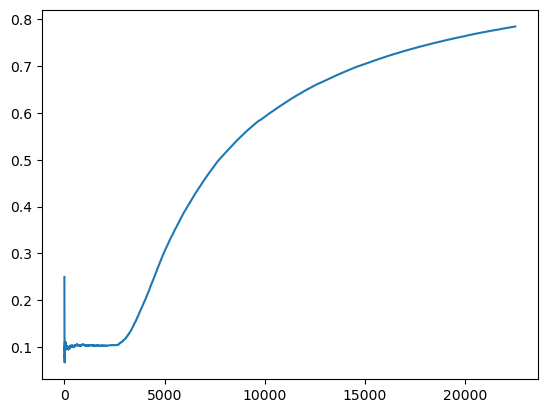

In [708]:
sns.lineplot(data=totalAcc)

In [ ]:
# can't set the neural network to 10, otherwise it kills the signal

Observations:
- A 10% accuracy is the same as baseline (random guessing)
- We initially set the number of layers to 100, but this apparently kills the signal since higher chance of a vanishing gradient
- Setting the learning rate a bit higher from (e^-3 to e^-1) also helped (probably after adding ReLUs)
- ReLU does help (see below)
- Also that's a really interesting pattern from batch 0 to batch 3000 ish (what's going on there?)
- **This may depend on the initial weight initialization where most weights were positive, therefore even with ReLU the layers were not sparse. But then eventually ReLU kills a few neurons, sparsifies/delinearizes the layers, and increases the signal-to-noise ratio of each SGD update.**

Questions:
- Why is ReLU (or any non-linear activation function) necessary here after each layer except at the output?
    - Hypothesis: 
        1) It sparsifies the outputs at each layer which minimizes big changes after each layer
        2) By minimizing big changes (v.s. changes without ReLU), only non-zero weights undergo SGD
        3) With only non-zero weights undergoing SGD, non-zero weights will undergo smaller backprop updates (the zero weights essentially "die" and we hope the dead weights are not the majority). 
        4) With the a) sparsification which causes "non-linear" matrix multiplications at each layer and b) smaller gradient updates during backpropagation, the **NN converges less stochastically towards a non-linear function**. 
        5) The convergence is a non-answer but the **higher signal, lesser stochastic gradient updates** is a good answer.
    - Answers:
        - **Universal approximation theorem**: stacked linear layers + ReLU can approximate any function (non-answer)
            - Proof by induction on number of layers
        - **Prevents vanishing gradient problem** common with sigmoid/tanh (another non-answer because we set *any* activation function), yet the vanishing gradient problem apparently arises as the layers increase
- The last output shouldn't have any clipping, since we need the full class separation for LogSoftmax
    - Hence it may even make sense for there to be LESS ReLUs as we approach output layer
- If conv1D is sufficient here, why/when do we need the fancier stuff? e.g. 2-D kernels, pooling, batch norms
    - We'll use some 3D (monochrome) dataset next time to see this need

Learnings:

    1. Categorical Cross-Entropy: applies LogSoftmax then NLLLoss
    2. Probability output would simply require LogSoftmax